#INSTALACIÓN

In [1]:
# Notebook specific dependencies
!pip install matplotlib tf-models-official==2.14.0 google-cloud-storage

!git clone https://github.com/Google-Health/imaging-research.git
!pip install imaging-research/cxr-foundation/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.6 MB/s eta 0:00:00
     ━━

#AUTENTICAR PARA ACCEDER A LOS DATOS

In [2]:
from google.colab import auth

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

#CXR FOUNDATION

##CARGAR LOS DATOS

In [3]:
import io
import os
from google.cloud import storage
import pandas as pd


# crear directorio data si no existe
if not os.path.exists('data'):
  os.mkdir('data')

In [4]:
full_labels_df = pd.read_csv("/content/result.csv")
full_labels_df = full_labels_df.drop("Unnamed: 0", axis = 1)
full_labels_df.head()

ImageID            Vista  \
0  226422365473064991153945518775386906975_60z035...  POSTEROANTERIOR   
1  255382349430812131213346302695382137812_i21lnn...              NaN   
2  314858274809507033202251388295400218490_h6hx5g...              NaN   
3  40604703051024461935381495336984044045_gu7f3e.png              NaN   
4  98999006540902083812954778469309304932_9ooxu4.png              NaN   

   COPD signs  heart insufficiency  normal  pneumonia  
0           0                    1       0          0  
1           0                    0       1          0  
2           0                    0       0          1  
3           1                    0       0          0  
4           1                    0       0          0

Cambiar a formato dicom

In [5]:
# cambiar a formato DICOM
full_labels_df['remote_dicom_file'] = full_labels_df['ImageID'].apply(lambda x: os.path.join('inputs', x))
full_labels_df

ImageID            Vista  \
0     226422365473064991153945518775386906975_60z035...  POSTEROANTERIOR   
1     255382349430812131213346302695382137812_i21lnn...              NaN   
2     314858274809507033202251388295400218490_h6hx5g...              NaN   
3     40604703051024461935381495336984044045_gu7f3e.png              NaN   
4     98999006540902083812954778469309304932_9ooxu4.png              NaN   
...                                                 ...              ...   
1493  196315278961068856812224497649522101179_1t2x7m...              NaN   
1494  239331385013052986216158124580522719268_7xob6d...               PA   
1495  239331385013052986216158124580522719268_7y9a1d...               LL   
1496  198117630279442083542714100636577220720_voyvpv...          LATERAL   
1497  198117630279442083542714100636577220720_voyvpt...  POSTEROANTERIOR   

      COPD signs  heart insufficiency  normal  pneumonia  \
0              0                    1       0          0   
1              0                    0       1          0   
2              0                    0       0          1   
3              1                    0       0          0   
4              1                    0       0          0   
...          ...                  ...     ...        ...   
1493           0                    0       1          0   
1494           0                    0       1          0   
1495           0                    0       1          0   
1496           1                    0       0          0   
1497           1                    0       0          0   

                                      remote_dicom_file  
0     inputs/226422365473064991153945518775386906975...  
1     inputs/255382349430812131213346302695382137812...  
2     inputs/314858274809507033202251388295400218490...  
3     inputs/40604703051024461935381495336984044045_...  
4     inputs/98999006540902083812954778469309304932_...  
...                                                 ...  
1493  inputs/196315278961068856812224497649522101179...  
1494  inputs/239331385013052986216158124580522719268...  
1495  inputs/239331385013052986216158124580522719268...  
1496  inputs/198117630279442083542714100636577220720...  
1497  inputs/198117630279442083542714100636577220720...  

[1498 rows x 7 columns]

In [6]:
DICOM_DIR = '/content/data/inputs'
EMBEDDINGS_DIR = '/content/data/outputs'

# Labels df of relevant files
df_labels = pd.DataFrame(full_labels_df.iloc[:,1:])

# Path for downloaded DICOMs
df_labels["dicom_file"] = df_labels["remote_dicom_file"].apply(
    lambda x: os.path.join(DICOM_DIR, os.path.basename(x)))
# Path for generated embeddings
df_labels["embedding_file"] =  df_labels['dicom_file'].apply(
    lambda x: os.path.join(EMBEDDINGS_DIR, os.path.basename(x).replace(".png", ".tfrecord")))

df_labels

Vista  COPD signs  heart insufficiency  normal  pneumonia  \
0     POSTEROANTERIOR           0                    1       0          0   
1                 NaN           0                    0       1          0   
2                 NaN           0                    0       0          1   
3                 NaN           1                    0       0          0   
4                 NaN           1                    0       0          0   
...               ...         ...                  ...     ...        ...   
1493              NaN           0                    0       1          0   
1494               PA           0                    0       1          0   
1495               LL           0                    0       1          0   
1496          LATERAL           1                    0       0          0   
1497  POSTEROANTERIOR           1                    0       0          0   

                                      remote_dicom_file  \
0     inputs/226422365473064991153945518775386906975...   
1     inputs/255382349430812131213346302695382137812...   
2     inputs/314858274809507033202251388295400218490...   
3     inputs/40604703051024461935381495336984044045_...   
4     inputs/98999006540902083812954778469309304932_...   
...                                                 ...   
1493  inputs/196315278961068856812224497649522101179...   
1494  inputs/239331385013052986216158124580522719268...   
1495  inputs/239331385013052986216158124580522719268...   
1496  inputs/198117630279442083542714100636577220720...   
1497  inputs/198117630279442083542714100636577220720...   

                                             dicom_file  \
0     /content/data/inputs/2264223654730649911539455...   
1     /content/data/inputs/2553823494308121312133463...   
2     /content/data/inputs/3148582748095070332022513...   
3     /content/data/inputs/4060470305102446193538149...   
4     /content/data/inputs/9899900654090208381295477...   
...                                                 ...   
1493  /content/data/inputs/1963152789610688568122244...   
1494  /content/data/inputs/2393313850130529862161581...   
1495  /content/data/inputs/2393313850130529862161581...   
1496  /content/data/inputs/1981176302794420835427141...   
1497  /content/data/inputs/1981176302794420835427141...   

                                         embedding_file  
0     /content/data/outputs/226422365473064991153945...  
1     /content/data/outputs/255382349430812131213346...  
2     /content/data/outputs/314858274809507033202251...  
3     /content/data/outputs/406047030510244619353814...  
4     /content/data/outputs/989990065409020838129547...  
...                                                 ...  
1493  /content/data/outputs/196315278961068856812224...  
1494  /content/data/outputs/239331385013052986216158...  
1495  /content/data/outputs/239331385013052986216158...  
1496  /content/data/outputs/198117630279442083542714...  
1497  /content/data/outputs/198117630279442083542714...  

[1498 rows x 8 columns]

In [7]:
cliente = storage.Client()
bucket = cliente.get_bucket('bucket-frandovi')

In [8]:
if not os.path.exists(DICOM_DIR):
    os.makedirs(DICOM_DIR) #crear el directorio

for _, row in df_labels.iterrows():
  blob = bucket.blob(row["remote_dicom_file"]) #descargar archivos dicom desde bucket de GCS
  if blob.exists():
    blob.download_to_filename(row["dicom_file"])
print("Finished downloading DICOM files!")

Finished downloading DICOM files!


In [9]:
if not os.path.exists(EMBEDDINGS_DIR):
    os.makedirs(EMBEDDINGS_DIR) #crear el directorio

##GENERAR EMBEDDINGS

###FORMATO DE ALMACENAMIENTO
- Los embeddings se almacenan en formato npz o tfrecord, en nuestro caso usaremos tfrecord


###VERSIÓN DEL EMBEDDING
- CXR_FOUNDATION:
- ELIXR:
- ELIXIR_IMG_CONTRASTIVE:

### SELECCIONAR EL EMBEDDING

In [10]:
from cxr_foundation.inference import ModelVersion
import shutil

EMBEDDING_VERSION = 'elixr'
if EMBEDDING_VERSION == 'cxr_foundation':
  MODEL_VERSION = ModelVersion.V1
  TOKEN_NUM = 1
  EMBEDDINGS_SIZE = 1376
elif EMBEDDING_VERSION == 'elixr':
  MODEL_VERSION = ModelVersion.V2
  TOKEN_NUM = 32
  EMBEDDINGS_SIZE = 768
elif EMBEDDING_VERSION == 'elixr_img_contrastive':
  MODEL_VERSION = ModelVersion.V2_CONTRASTIVE
  TOKEN_NUM = 32
  EMBEDDINGS_SIZE = 128
if not os.path.exists(EMBEDDINGS_DIR):
  os.makedirs(EMBEDDINGS_DIR)
else:
  # Empty embedding dir to avoid caching when switching embedding versions
  shutil.rmtree(EMBEDDINGS_DIR)
  os.makedirs(EMBEDDINGS_DIR)

In [11]:
print(EMBEDDING_VERSION)
print(EMBEDDINGS_SIZE)
print(TOKEN_NUM)
print(MODEL_VERSION)

elixr
768
32
ModelVersion.V2


In [12]:
import logging

from cxr_foundation.inference import generate_embeddings, InputFileType, OutputFileType, ModelVersion


logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [106]:
# prompt: descomprimir el archivo con ruta /content/outputs.zip en /content/data

!unzip -j /content/outputs.zip -d /content/data/outputs


Archive:  /content/outputs.zip
  inflating: /content/data/outputs/108438646617868521566843306999486317849_fnzh36.tfrecord  
  inflating: /content/data/outputs/159232621492356748738216279834896958547_vadv82.tfrecord  
  inflating: /content/data/outputs/77005557143097089476338543800711980610_6ti1h0.tfrecord  
  inflating: /content/data/outputs/95365162185303012800172520650239597563_7vtosn.tfrecord  
  inflating: /content/data/outputs/247038543581045036239112520838799349270_atdx71.tfrecord  
  inflating: /content/data/outputs/97620346739760702157845324608369283125_k4dco0.tfrecord  
  inflating: /content/data/outputs/190982161191095071906882535813256029076_e4lad3.tfrecord  
  inflating: /content/data/outputs/315978945273845536584734593414341901439_f5y4rr.tfrecord  
  inflating: /content/data/outputs/127746587283185300381539471498824296580_0nuhlw.tfrecord  
  inflating: /content/data/outputs/142694205460616953885130383795686432721_tda5v5.tfrecord  
  inflating: /content/data/outputs/3998777

In [ ]:
# Generate all the embeddings in .tfrecord format
#generate_embeddings(input_files=df_labels["dicom_file"].values, output_dir=EMBEDDINGS_DIR,
#    input_type=InputFileType.PNG, output_type=OutputFileType.TFRECORD, model_version=MODEL_VERSION)

In [ ]:
# prompt: descargar el contenido de la carpeta  /content/data/outputs a local

# Create a zip archive of the outputs directory
!zip -r outputs.zip /content/data/outputs

# Import the necessary module
from google.colab import files

# Download the zip archive to local
files.download('/content/outputs.zip')

updating: content/data/outputs/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#ENFOQUE 1: ENFERMO O NO ENFERMO

##CXR FOUNDATION

### SEPARAR EN ENTRENAMIENTO, VALIDACIÓN Y TEST

In [16]:
df_labels = df_labels.rename(columns={'COPD signs': 'COPD_signs', 'heart insufficiency': 'heart_insufficiency'})

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_validate = train_test_split(df_labels.iloc[:,[3,5,6,7]], test_size=0.15)

### ELECCIÓN ÓPTIMA DE HIPERPARÁMETROS
Entrenamos un modelo usando los embeddings generados en el paso anterior

In [ ]:
import tensorflow as tf
import tensorflow_models as tfm
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy


def create_model(heads,
                 # token_num=1 for original CXR foundation embedding
                 # token_num=32 for ELIXR embedding
                 token_num=1,
                 embeddings_size=1376,
                 learning_rate=0.02,
                 end_lr_factor=1,
                 dropout=0.2,
                 decay_steps=1000,
                 loss_weights=None,
                 hidden_layer_sizes=[512,256, 128],
                 weight_decay=None,
                 seed=None) -> tf.keras.Model:
  """
  Creates linear probe or multilayer perceptron using LARS + cosine decay.


  """
  inputs = tf.keras.Input(shape=(token_num * embeddings_size,))
  inputs_reshape = tf.keras.layers.Reshape((token_num, embeddings_size))(inputs)
  inputs_pooled = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(inputs_reshape)
  hidden = inputs_pooled
  # If no hidden_layer_sizes are provided, model will be a linear probe.
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(hidden)

    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.HeUniform(seed=seed)
      )(hidden)

  model = tf.keras.Model(inputs, output)
  learning_rate_fn = tf.keras.experimental.CosineDecay(
      tf.cast(learning_rate, tf.float32),
      tf.cast(decay_steps, tf.float32),
      alpha=tf.cast(end_lr_factor, tf.float32))


  model.compile(
      optimizer = tfm.optimization.lars.LARS(
          learning_rate=learning_rate_fn),
      loss=BinaryCrossentropy(),
     weighted_metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [ ]:
from cxr_foundation import embeddings_data

# Create training and validation Datasets
training_data = embeddings_data.get_dataset(
    filenames=df_train["embedding_file"].values,
    labels=df_train.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)


validation_data = embeddings_data.get_dataset(
    filenames=df_validate["embedding_file"].values,
    labels=df_validate.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)

In [ ]:

# Create and train the model
model = create_model(
    pd.DataFrame(df_train.iloc[:, 0]).columns.tolist(),
    token_num=TOKEN_NUM,
    embeddings_size = EMBEDDINGS_SIZE,
)

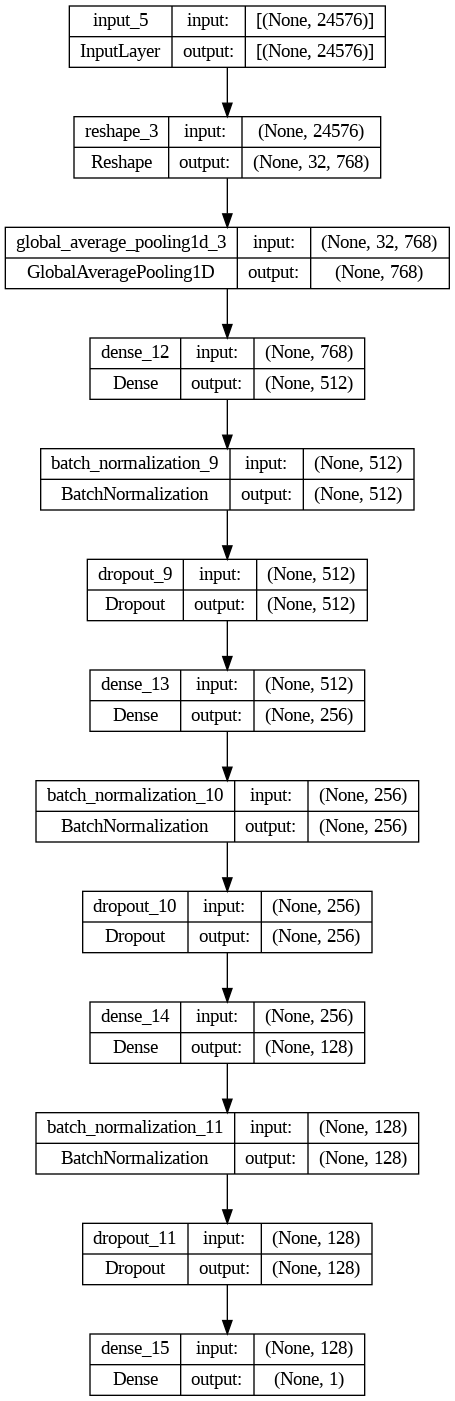

In [ ]:
from tensorflow.keras.utils import plot_model

# Generar el gráfico del modelo
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


###ENTRENAMIENTO

In [ ]:
Y_train = df_train.iloc[:, 0]

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
class_weights

array([0.73754345, 1.55243902])

In [ ]:
class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}
class_weights_dict

{0: 0.7375434530706837, 1: 1.552439024390244}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
hist_cxr = model.fit(
    x=training_data.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(1).cache(),
    epochs=500,
    #callbacks = early_stopping,
    shuffle = True,
    class_weight = class_weights_dict
)

Epoch 1/500
3/3 [==============================] - 4s 575ms/step - loss: 18.8699 - false_positives_3: 323.7816 - false_negatives_3: 302.7256 - true_positives_3: 333.7744 - true_negatives_3: 312.7184 - auc_3: 0.5055 - auc_pr: 0.4868 - val_loss: 18.5600 - val_false_positives_3: 30.0000 - val_false_negatives_3: 46.0000 - val_true_positives_3: 13.0000 - val_true_negatives_3: 136.0000 - val_auc_3: 0.5248 - val_auc_pr: 0.2968
Epoch 2/500
3/3 [==============================] - 0s 212ms/step - loss: 18.8430 - false_positives_3: 330.4194 - false_negatives_3: 312.0403 - true_positives_3: 324.4597 - true_negatives_3: 306.0805 - auc_3: 0.4967 - auc_pr: 0.4844 - val_loss: 18.5580 - val_false_positives_3: 33.0000 - val_false_negatives_3: 46.0000 - val_true_positives_3: 13.0000 - val_true_negatives_3: 133.0000 - val_auc_3: 0.5287 - val_auc_pr: 0.2994
Epoch 3/500
3/3 [==============================] - 0s 214ms/step - loss: 18.8096 - false_positives_3: 309.7682 - false_negatives_3: 279.4390 - true_posi

###GENERAR PREDICCIONES

In [ ]:
predicciones_cxr = model.predict(validation_data.batch(1).cache())


225/225 [==============================] - 0s 2ms/step


### RESULTADOS

####CURVAS DE APRENDIZAJE

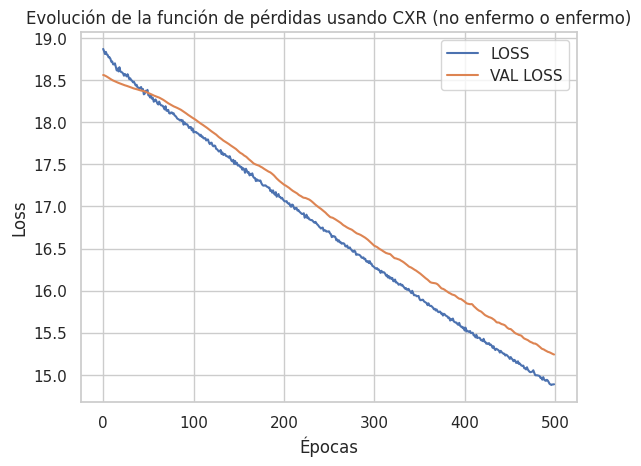

In [ ]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_cxr.history['loss'],label="LOSS")
plt.plot(hist_cxr.history['val_loss'],label="VAL LOSS")
plt.title('Evolución de la función de pérdidas usando CXR (no enfermo o enfermo)')
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
hist_cxr.history.keys()

dict_keys(['loss', 'false_positives_3', 'false_negatives_3', 'true_positives_3', 'true_negatives_3', 'auc_3', 'auc_pr', 'val_loss', 'val_false_positives_3', 'val_false_negatives_3', 'val_true_positives_3', 'val_true_negatives_3', 'val_auc_3', 'val_auc_pr'])

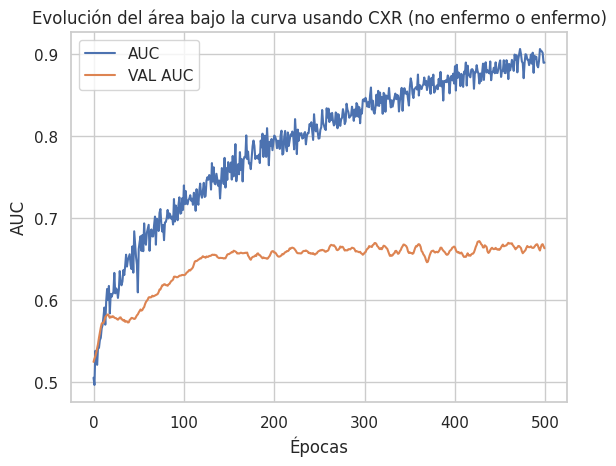

In [ ]:
# Ploteamos la evolucion de la métrica durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_cxr.history['auc_3'],label="AUC")
plt.plot(hist_cxr.history['val_auc_3'],label="VAL AUC")
plt.title('Evolución del área bajo la curva usando CXR (no enfermo o enfermo)')
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [93]:
def plot_roc_curve(fpr, tpr, n_classes,problem_type, nombre_clase):

  sns.set(style="white")
  plt.figure(figsize=(10, 8))

  if problem_type == "binary":
    for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label='ROC class ' + nombre_clase[i])
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(False)
    plt.show()

    sns.set(style="white")
  plt.figure(figsize=(10, 8))
  if problem_type == "multiclass":
    for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label='ROC class ' + nombre_clase[i])
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(False)
    plt.show()


def ClassificationReport(n_classes, predicciones, Y_test, problem_type, nombre_clase):
  # Compute ROC curve and ROC area for each class
  lista_acc = []
  fpr = dict()
  tpr = dict()
  thresholds = dict()
  roc_auc = dict()
  predicciones_binarias_lista = []

  if problem_type == "binary":
    for i in range(n_classes):
        #nos quedamos con la clase positiva
        predicciones_clase_positiva = predicciones[:, i]

        fpr[i], tpr[i], thresholds[i] = roc_curve(Y_test, predicciones_clase_positiva)
        roc_auc[i] = auc(fpr[i], tpr[i])
        print("Área bajo la curva de la clase ",nombre_clase[i], ":", roc_auc[i])

        optimal_idx = np.argmax(tpr[i] - fpr[i])
        optimal_threshold = thresholds[i][optimal_idx]
        print("UMBRAL:", optimal_threshold)
        #plot_roc_curve(fpr[i], tpr[i])


        # Aplicar umbral para convertir a predicciones binarias
        predicciones_binarias = (predicciones_clase_positiva > optimal_threshold).astype(int)
        predicciones_binarias_lista.append(predicciones_binarias)
        acc = accuracy_score(Y_test.T, predicciones_binarias_lista[i])
        lista_acc.append(acc)
        cr = classification_report(Y_test.T, predicciones_binarias_lista[i])

        print("cr: \n", cr)

  if problem_type == "multiclass":
    Y_test = np.array(Y_test)
    for i in range(n_classes):
        #nos quedamos con la clase positiva
        predicciones_clase_positiva = predicciones[:, i]

        fpr[i], tpr[i], thresholds[i] = roc_curve(Y_test[:,i], predicciones_clase_positiva)
        roc_auc[i] = auc(fpr[i], tpr[i])
        print("Área bajo la curva de la clase",nombre_clase[i], ":", roc_auc[i])

        optimal_idx = np.argmax(tpr[i] - fpr[i])
        optimal_threshold = thresholds[i][optimal_idx]
        print("UMBRAL:", optimal_threshold)


        # Aplicar umbral para convertir a predicciones binarias
        predicciones_binarias = (predicciones_clase_positiva > optimal_threshold).astype(int)
        predicciones_binarias_lista.append(predicciones_binarias)
        acc = accuracy_score(Y_test[:,i].T, predicciones_binarias_lista[i])


        lista_acc.append(acc)
        cr = classification_report(Y_test[:,i].T, predicciones_binarias_lista[i])
        print("cr: \n", cr)


  return predicciones_binarias_lista, fpr, tpr

def ConfusionMatrix(n_classes, Y_test, predicciones_binarias_lista, nombre_clase, problem_type):

  if problem_type == "binary":

    # Configuración de seaborn para mejores gráficos
    sns.set(style="whitegrid")
    # Crear subplots para cada matriz de confusión
    fig, ax = plt.subplots()


    confusion_matrices = []
    for i in range(n_classes):
        cm = confusion_matrix(Y_test[:,i], predicciones_binarias_lista[:,i])
        confusion_matrices.append(cm)

        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax)
        ax.set_title(f'Clase {nombre_clase[i]}')
        ax.set_xlabel('Predicho')
        ax.set_ylabel('Verdadero')

    plt.tight_layout()
    plt.show()


  if problem_type == "multiclass":
    predicciones_binarias_lista = np.array(predicciones_binarias_lista)
    Y_test = np.array(Y_test)

    etiquetas_finales = np.argmax(predicciones_binarias_lista, axis=1)
    Y_test = np.argmax(Y_test, axis=1)

    cm = confusion_matrix(Y_test,etiquetas_finales)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=nombre_clase, yticklabels=nombre_clase)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predicciones')
    plt.title('Matriz de Confusión')
    plt.show()


####CLASSIFICATION REPORT

In [ ]:
predicciones_binarias, fpr, tpr = ClassificationReport(1, predicciones_cxr, df_validate.iloc[:, 0].values, "binary", ["NORMAL"])

Área bajo la curva de la clase  NORMAL : 0.6634674290381867
UMBRAL: 0.4108047
cr: 
               precision    recall  f1-score   support

           0       0.87      0.51      0.64       166
           1       0.36      0.78      0.49        59

    accuracy                           0.58       225
   macro avg       0.61      0.64      0.57       225
weighted avg       0.73      0.58      0.60       225



####CURVA ROC

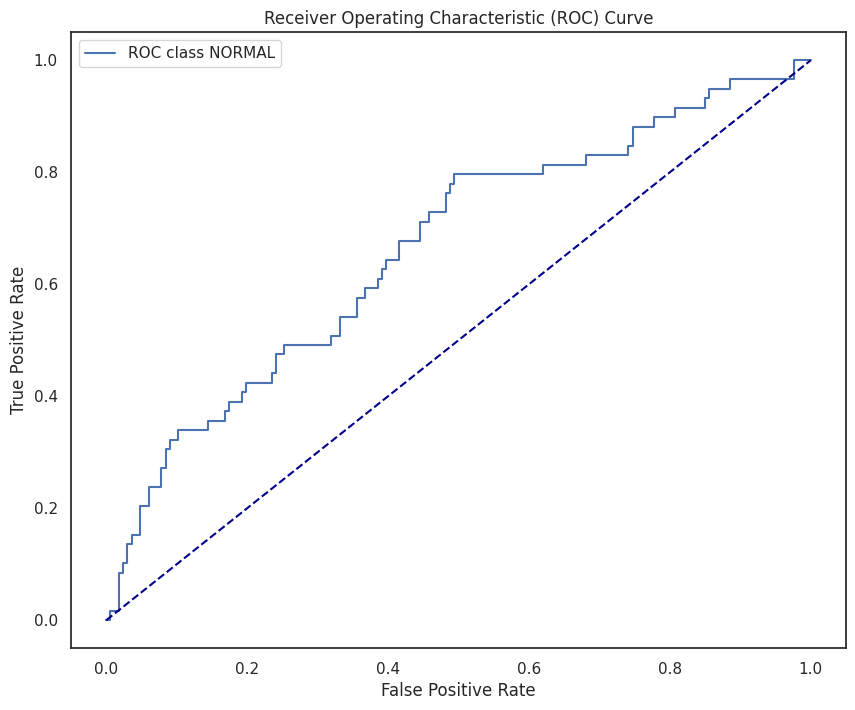

In [ ]:
#%matplotlib inline
plot_roc_curve(fpr, tpr, 1,"binary", ["NORMAL"])

#### MATRIZ DE CONFUSIÓN

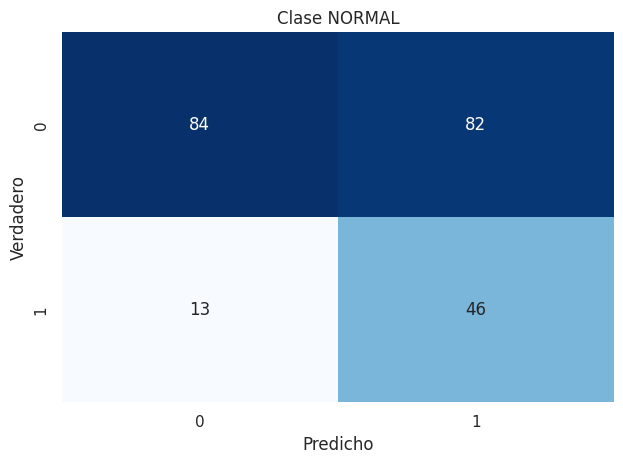

In [ ]:
ConfusionMatrix(1, df_validate.iloc[:, 0].values.reshape(-1,1), np.array(predicciones_binarias).T.reshape(-1,1), ["NORMAL"])

##RESNET

###DEFINIR MODELO

Definir el modelo base

In [19]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout

#1.- crear una primera capa para forzar el tamaño de las imagenes de entrada
input_tensor = Input(shape=(512, 512, 3))

#2.- Añadir segunda capa de preprocesado de imagenes
resize_rescale_hf = Sequential([layers.Rescaling(1./255),
                                layers.Resizing(224,224)
                                ],
                               name="preprocessing")

entrada_preprocesada = resize_rescale_hf(input_tensor)

model_base = ResNet50(input_tensor = entrada_preprocesada,
                      weights='imagenet',
                      include_top = False)


94765736/94765736 [==============================] - 6s 0us/step


Definir la capa de salida

In [ ]:
x = model_base.output
#x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)


x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)

predictions = Dense(1, activation='sigmoid')(x)


Construir el modelo a partir del modelo base y la capa de salida

In [ ]:
model_resnet = Model(inputs=model_base.input, outputs=predictions)

In [ ]:

# Descongelar todas las capas
for layer in model_resnet.layers:
    layer.trainable = True

###ELECCIÓN ÓPTIMA DE HIPERPARÁMETROS

In [ ]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

optimizador = Adam(learning_rate = 1e-3, weight_decay = 0.01)

model_resnet.compile(optimizer = optimizador,
              loss='binary_crossentropy',
              weighted_metrics=[
                  tf.keras.metrics.FalsePositives(),
                  tf.keras.metrics.FalseNegatives(),
                  tf.keras.metrics.TruePositives(),
                  tf.keras.metrics.TrueNegatives(),
                  tf.keras.metrics.AUC(),
                  tf.keras.metrics.AUC(curve='PR', name='auc_pr')])


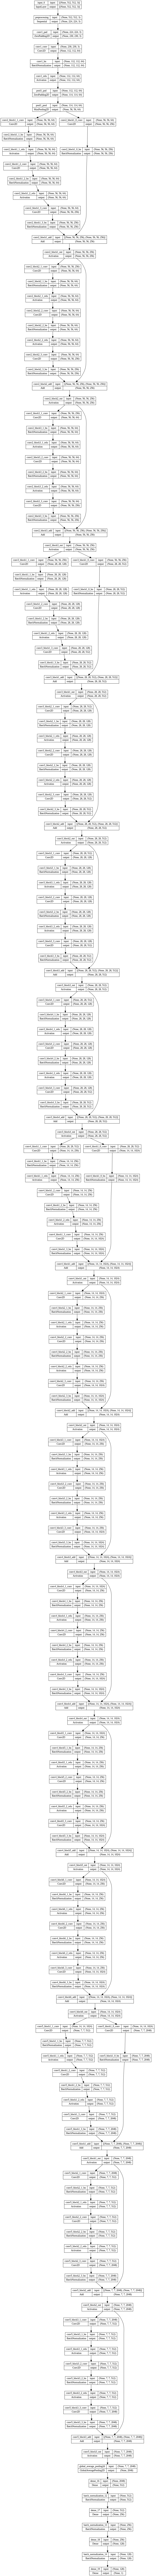

In [ ]:
# Generar el gráfico del modelo
plot_model(model_resnet, to_file='model_resnet_plot.png', show_shapes=True, show_layer_names=True)

Cargar imágenes en forma de array

In [21]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

def load_images_from_directory(directory, target_size=(512, 512)):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            #img_array = np.array(img)
            images.append(img_rgb)
    return np.array(images)


In [22]:
# Especifica el directorio donde se encuentran las imágenes
directory = "/content/data/inputs"

# Cargar imágenes en un array
data = load_images_from_directory(directory)

# Verificar el tamaño del array
print(data.shape)


(1498, 512, 512, 3)


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
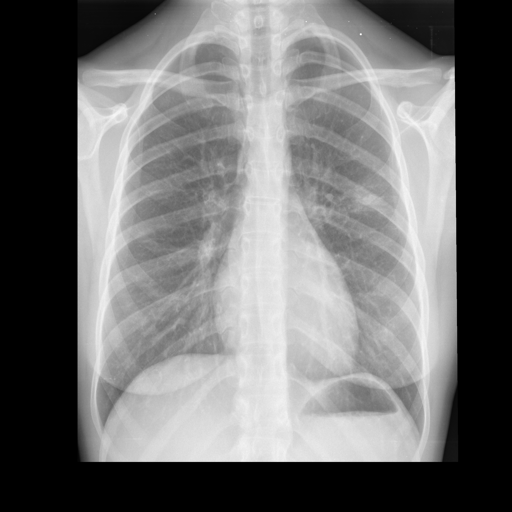

In [ ]:
data[0]

###SEPARAR EN ENTRENAMIENTO, VALIDACIÓN Y TEST


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, df_labels["normal"], test_size=0.15, random_state=42)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
print("Dimension de X_train", X_train.shape)
print("Dimension de Y_train", Y_train.shape)
print("\nDimension de X_test", X_test.shape)
print("Dimension de Y_test", Y_test.shape)


Dimension de X_train (1273, 512, 512, 3)
Dimension de Y_train (1273,)

Dimension de X_test (225, 512, 512, 3)
Dimension de Y_test (225,)


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
class_weights

array([0.72083805, 1.63205128])

In [ ]:
class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}
class_weights_dict


{0: 0.7208380520951302, 1: 1.632051282051282}

### ENTRENAMIENTO

In [ ]:
hist_resnet = model_resnet.fit(X_train, Y_train,
                               batch_size=128,
                               epochs=50,
                               validation_data = (X_test, Y_test),
                               class_weight = class_weights_dict)


Epoch 1/50
10/10 [==============================] - 98s 7s/step - loss: 0.9436 - false_positives_5: 281.1269 - false_negatives_5: 326.4102 - true_positives_5: 310.0897 - true_negatives_5: 355.3732 - auc_5: 0.5212 - auc_pr: 0.5108 - val_loss: 5.4396 - val_false_positives_5: 0.0000e+00 - val_false_negatives_5: 79.0000 - val_true_positives_5: 0.0000e+00 - val_true_negatives_5: 146.0000 - val_auc_5: 0.5000 - val_auc_pr: 0.3511
Epoch 2/50
10/10 [==============================] - 72s 7s/step - loss: 0.7700 - false_positives_5: 305.6353 - false_negatives_5: 301.9295 - true_positives_5: 334.5705 - true_negatives_5: 330.8647 - auc_5: 0.5381 - auc_pr: 0.5452 - val_loss: 19.8225 - val_false_positives_5: 146.0000 - val_false_negatives_5: 0.0000e+00 - val_true_positives_5: 79.0000 - val_true_negatives_5: 0.0000e+00 - val_auc_5: 0.5000 - val_auc_pr: 0.3511
Epoch 3/50
10/10 [==============================] - 74s 7s/step - loss: 0.7425 - false_positives_5: 306.3562 - false_negatives_5: 306.8257 - true

### CURVAS DE APRENDIZAJE

In [ ]:
hist_resnet.history.keys()

dict_keys(['loss', 'false_positives_5', 'false_negatives_5', 'true_positives_5', 'true_negatives_5', 'auc_5', 'auc_pr', 'val_loss', 'val_false_positives_5', 'val_false_negatives_5', 'val_true_positives_5', 'val_true_negatives_5', 'val_auc_5', 'val_auc_pr'])

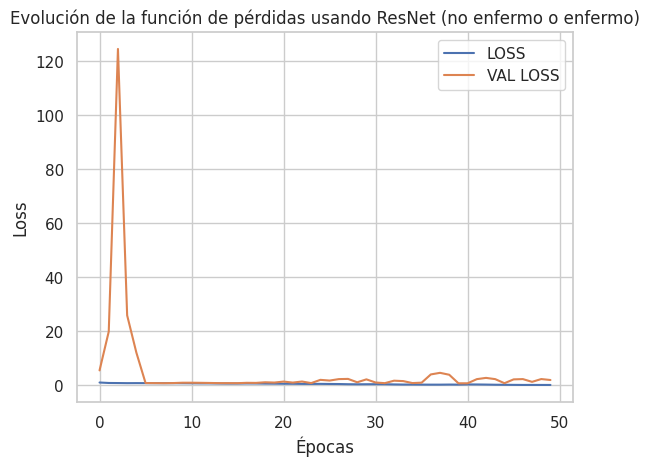

In [ ]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_resnet.history['loss'],label="LOSS")
plt.plot(hist_resnet.history['val_loss'],label="VAL LOSS")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando ResNet (no enfermo o enfermo)')
plt.legend()
plt.show()

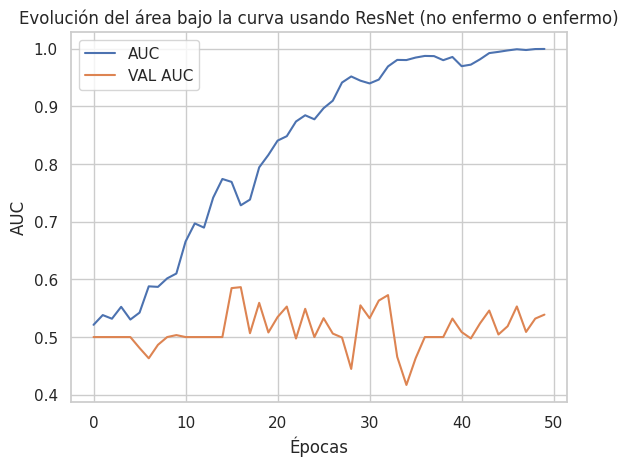

In [ ]:
# Ploteamos la evolucion de la métrica durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_resnet.history['auc_5'],label="AUC")
plt.plot(hist_resnet.history['val_auc_5'],label="VAL AUC")
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.title('Evolución del área bajo la curva usando ResNet (no enfermo o enfermo)')
plt.legend()
plt.show()

### GENERAR PREDICCIONES

In [ ]:
predicciones_resnet = model_resnet.predict(X_test)

8/8 [==============================] - 5s 441ms/step


###RESULTADOS

####CLASSIFICATION REPORT

In [ ]:
predicciones_binarias_resnet, fpr_binary_resnet, tpr_binary_resnet = ClassificationReport(1, predicciones_resnet, Y_test, "binary", ["NORMAL"])

Área bajo la curva de la clase  NORMAL : 0.5401421883128142
UMBRAL: 0.94690084
cr: 
               precision    recall  f1-score   support

           0       0.67      0.76      0.71       146
           1       0.42      0.32      0.36        79

    accuracy                           0.60       225
   macro avg       0.54      0.54      0.54       225
weighted avg       0.58      0.60      0.59       225



#### CURVA ROC

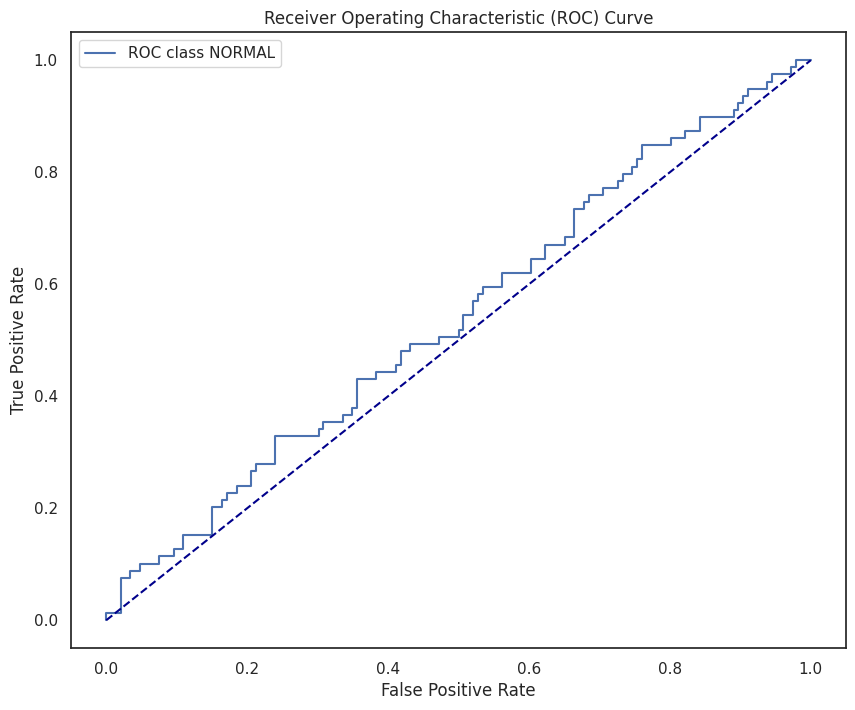

In [ ]:
plot_roc_curve(fpr_binary_resnet, tpr_binary_resnet, 1,"binary", ["NORMAL"])

#### MATRIZ DE CONFUSIÓN

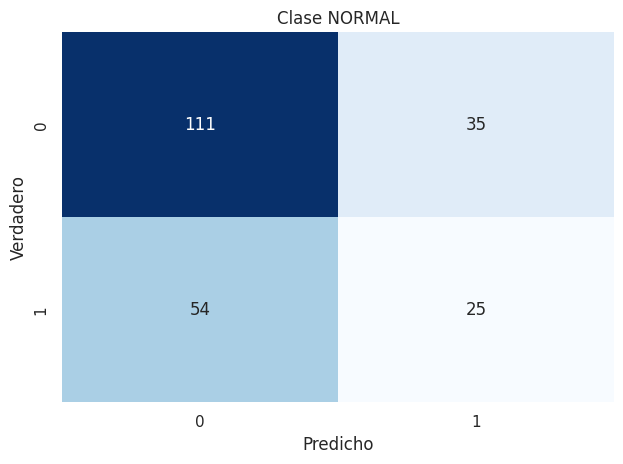

In [ ]:
ConfusionMatrix(1, Y_test.reshape(-1,1), np.array(predicciones_binarias_resnet).T.reshape(-1,1), ["NORMAL"])


#ENFOQUE 2: CLASIFICACIÓN MULTICLASE

##CXR FOUNDATION

###SEPARAR EN ENTRENAMIENTO, VALIDACIÓN Y TEST

In [101]:
from sklearn.model_selection import train_test_split

df_train_multiclass, df_validate_multiclass = train_test_split(df_labels.iloc[:,1:], test_size=0.15)

###ELECCIÓN ÓPTIMA DE HIPERPARÁMETROS

In [102]:
import tensorflow as tf
import tensorflow_models as tfm
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from keras.metrics import BinaryAccuracy


def create_model_multiclass(heads,
                 # token_num=1 for original CXR foundation embedding
                 # token_num=32 for ELIXR embedding
                 token_num=1,
                 embeddings_size=1376,
                 learning_rate=0.02,
                 end_lr_factor=1,
                 dropout=0.2,
                 decay_steps=1000,
                 loss_weights=None,
                 hidden_layer_sizes=[512, 256, 128],
                 weight_decay=None,
                 seed=None) -> tf.keras.Model:
  """
  Creates linear probe or multilayer perceptron using LARS + cosine decay.


  """
  inputs = tf.keras.Input(shape=(token_num * embeddings_size,))
  inputs_reshape = tf.keras.layers.Reshape((token_num, embeddings_size))(inputs)
  inputs_pooled = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(inputs_reshape)
  hidden = inputs_pooled
  # If no hidden_layer_sizes are provided, model will be a linear probe.
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(hidden)

    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='softmax',
    kernel_initializer=tf.keras.initializers.HeUniform(seed=seed)
      )(hidden)

  model = tf.keras.Model(inputs, output)
  learning_rate_fn = tf.keras.experimental.CosineDecay(
      tf.cast(learning_rate, tf.float32),
      tf.cast(decay_steps, tf.float32),
      alpha=tf.cast(end_lr_factor, tf.float32))


  model.compile(
      optimizer = tfm.optimization.lars.LARS(
          learning_rate=learning_rate_fn),
      loss=CategoricalCrossentropy(from_logits= True),
     weighted_metrics=[
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.AUC(curve='PR', name='auc_pr')
        ])
  return model

In [103]:
from cxr_foundation import embeddings_data

# Create training and validation Datasets
training_data_multiclass = embeddings_data.get_dataset(
    filenames=df_train_multiclass["embedding_file"].values,
    labels=df_train_multiclass.iloc[:, :4].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)


validation_data_multiclass = embeddings_data.get_dataset(
    filenames=df_validate_multiclass["embedding_file"].values,
    labels=df_validate_multiclass.iloc[:, :4].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)

In [104]:
# Create and train the model
model_multiclass = create_model_multiclass(
    pd.DataFrame(df_train_multiclass.iloc[:, :4]).columns.tolist(),
    token_num=TOKEN_NUM,
    embeddings_size = EMBEDDINGS_SIZE,
)

###ENTRENAMIENTO

In [107]:
hist_cxr_multiclass = model_multiclass.fit(
    x=training_data_multiclass.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data_multiclass.batch(1).cache(),
    epochs=500,
    #callbacks = early_stopping,
    shuffle = True)

Epoch 1/500
3/3 [==============================] - 1s 554ms/step - loss: 19.9602 - false_positives_6: 637.0000 - false_negatives_6: 1075.0000 - true_positives_6: 198.0000 - true_negatives_6: 3182.0000 - auc_6: 0.4932 - auc_pr: 0.2436 - val_loss: 20.2449 - val_false_positives_6: 148.0000 - val_false_negatives_6: 148.0000 - val_true_positives_6: 77.0000 - val_true_negatives_6: 527.0000 - val_auc_6: 0.6155 - val_auc_pr: 0.3058
Epoch 2/500
3/3 [==============================] - 0s 221ms/step - loss: 19.9408 - false_positives_6: 612.0000 - false_negatives_6: 1073.0000 - true_positives_6: 200.0000 - true_negatives_6: 3207.0000 - auc_6: 0.5006 - auc_pr: 0.2485 - val_loss: 20.2105 - val_false_positives_6: 148.0000 - val_false_negatives_6: 148.0000 - val_true_positives_6: 77.0000 - val_true_negatives_6: 527.0000 - val_auc_6: 0.6148 - val_auc_pr: 0.3051
Epoch 3/500
3/3 [==============================] - 0s 221ms/step - loss: 19.9507 - false_positives_6: 622.0000 - false_negatives_6: 1064.0000 - 

###CURVAS DE APRENDIZAJE

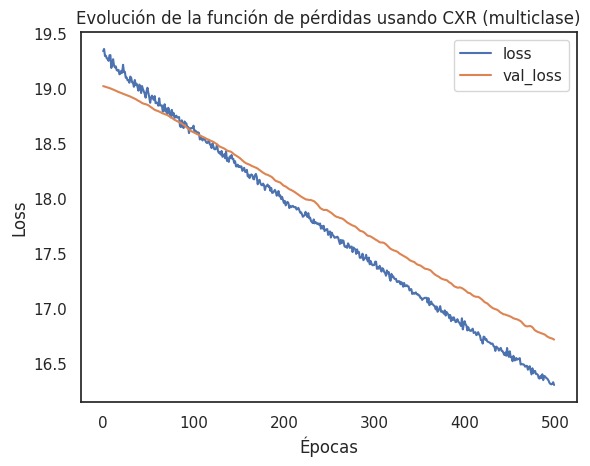

In [ ]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_cxr_multiclass.history['loss'],label="loss")
plt.plot(hist_cxr_multiclass.history['val_loss'],label="val_loss")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando CXR (multiclase)')
plt.legend()
plt.show()

In [108]:
hist_cxr_multiclass.history.keys()

dict_keys(['loss', 'false_positives_6', 'false_negatives_6', 'true_positives_6', 'true_negatives_6', 'auc_6', 'auc_pr', 'val_loss', 'val_false_positives_6', 'val_false_negatives_6', 'val_true_positives_6', 'val_true_negatives_6', 'val_auc_6', 'val_auc_pr'])

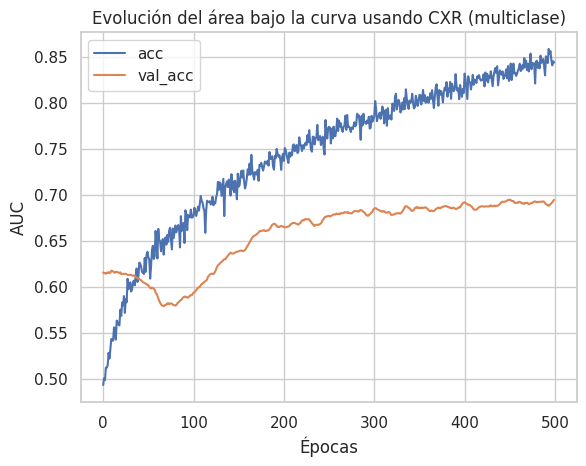

In [113]:
# Ploteamos la evolucion de la métrica durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_cxr_multiclass.history['auc_6'],label="acc")
plt.plot(hist_cxr_multiclass.history['val_auc_6'],label="val_acc")
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.title('Evolución del área bajo la curva usando CXR (multiclase)')
plt.legend()
plt.show()

###PREDICCIONES

In [ ]:
predicciones_cxr_multiclass = model_multiclass.predict(validation_data_multiclass.batch(1).cache())

225/225 [==============================] - 0s 2ms/step


###RESULTADOS

####CLASSIFICATION REPORT

In [ ]:
predicciones_binarias_multiclass, fpr, tpr = ClassificationReport(4,
                                                        predicciones_cxr_multiclass,
                                                        df_validate_multiclass.iloc[:, :4].values,
                                                        problem_type = "multiclass",
                                                        nombre_clase = df_labels.columns[[1,2,3,4]].tolist())

Área bajo la curva de la clase COPD_signs : 0.611111111111111
UMBRAL: 0.22536498
cr: 
               precision    recall  f1-score   support

           0       0.79      0.63      0.70       162
           1       0.38      0.57      0.45        63

    accuracy                           0.61       225
   macro avg       0.58      0.60      0.58       225
weighted avg       0.67      0.61      0.63       225

Área bajo la curva de la clase heart_insufficiency : 0.7709330143540669
UMBRAL: 0.18586206
cr: 
               precision    recall  f1-score   support

           0       0.97      0.70      0.82       209
           1       0.16      0.75      0.27        16

    accuracy                           0.71       225
   macro avg       0.57      0.73      0.54       225
weighted avg       0.92      0.71      0.78       225

Área bajo la curva de la clase normal : 0.6679999999999999
UMBRAL: 0.2602742
cr: 
               precision    recall  f1-score   support

           0       0.79 

####CURVA ROC

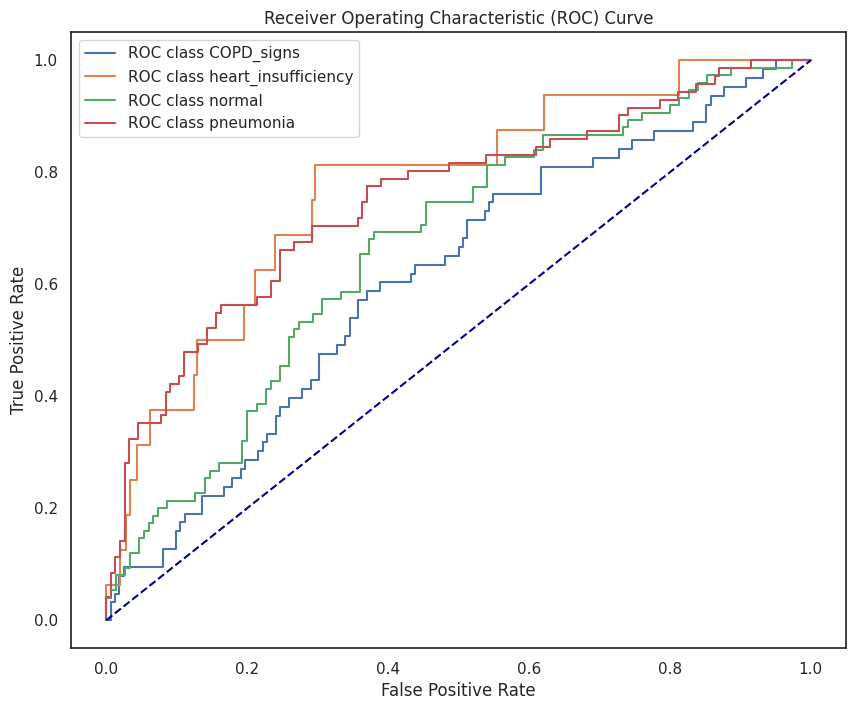

In [ ]:
#%matplotlib inline
plot_roc_curve(fpr, tpr, 4, "multiclass", df_labels.columns[[1,2,3,4]].tolist())


####MATRIZ DE CONFUSIÓN

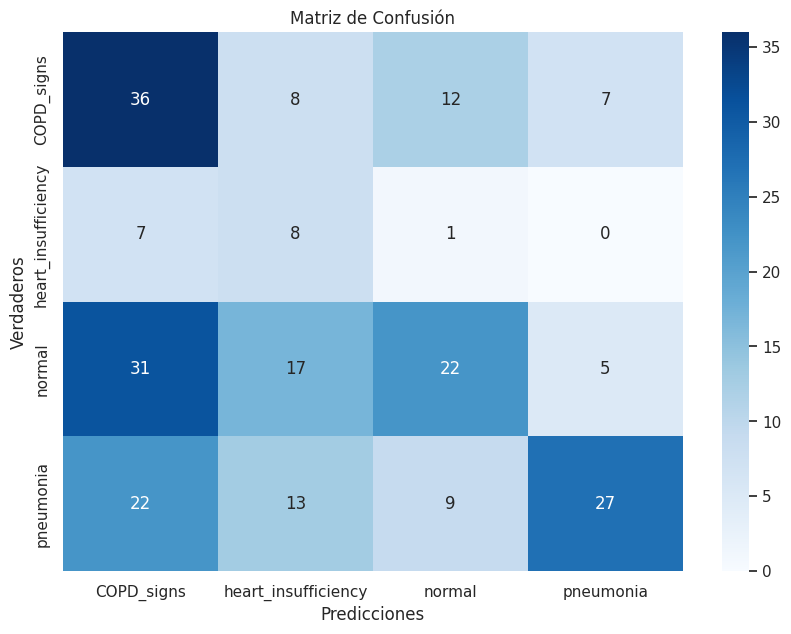

In [ ]:

ConfusionMatrix(4, df_validate_multiclass.iloc[:, :4].values,
                np.array(predicciones_binarias_multiclass).T,
                nombre_clase = df_labels.columns[[1,2,3,4]].tolist(),
                problem_type = "multiclass")

##RESNET

###SEPARAR EN ENTRENAMIENTO, VALIDACIÓN Y TEST

In [ ]:
from sklearn.model_selection import train_test_split
X_train_multiclass, X_test_multiclass, Y_train_multiclass, Y_test_multiclass = train_test_split(data,  df_labels.iloc[:, 1:5], test_size=0.15, random_state=42)

### DEFINIR MODELO

Definimos la capa de salida sobre el modelo base anterior

In [ ]:
x = model_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)


x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)

predictions = Dense(4, activation='softmax')(x)

In [ ]:
model_resnet_multiclass = Model(inputs=model_base.input, outputs=predictions)

In [ ]:
# Descongelar las últimas 100 capas
for layer in model_resnet_multiclass.layers:
    layer.trainable = True

###ELECCIÓN ÓPTIMA DE HIPERPARÁMETROS

In [ ]:
from tensorflow.keras.optimizers import Adam
import keras
optimizador = Adam(learning_rate = 1e-3, weight_decay = 0.01)

model_resnet_multiclass.compile(optimizer = optimizador,  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(),
              weighted_metrics=[
                  tf.keras.metrics.FalsePositives(),
                  tf.keras.metrics.FalseNegatives(),
                  tf.keras.metrics.TruePositives(),
                  tf.keras.metrics.TrueNegatives(),
                  tf.keras.metrics.AUC(),
                  tf.keras.metrics.AUC(curve='PR', name='auc_pr')])


###ENTRENAMIENTO

In [ ]:
hist_resnet_multiclass = model_resnet_multiclass.fit(X_train_multiclass, Y_train_multiclass,
                               batch_size=128,
                               epochs=50,
                               validation_data = (X_test_multiclass, Y_test_multiclass))

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 1.6660 - false_positives_9: 278.0000 - false_negatives_9: 1157.0000 - true_positives_9: 116.0000 - true_negatives_9: 3541.0000 - auc_9: 0.5286 - auc_pr: 0.2727

10/10 [==============================] - 95s 7s/step - loss: 1.6660 - false_positives_9: 278.0000 - false_negatives_9: 1157.0000 - true_positives_9: 116.0000 - true_negatives_9: 3541.0000 - auc_9: 0.5286 - auc_pr: 0.2727 - val_loss: 63253.5195 - val_false_positives_9: 163.0000 - val_false_negatives_9: 163.0000 - val_true_positives_9: 62.0000 - val_true_negatives_9: 512.0000 - val_auc_9: 0.5170 - val_auc_pr: 0.2623
Epoch 2/50
10/10 [==============================] - 73s 7s/step - loss: 1.4551 - false_positives_9: 84.0000 - false_negatives_9: 1248.0000 - true_positives_9: 25.0000 - true_negatives_9: 3735.0000 - auc_9: 0.5323 - auc_pr: 0.2707 - val_loss: 737.9529 - val_false_positives_9: 154.0000 - val_false_negatives_9: 154.0000 - val_true_positives_9: 71.0000 - val_true_negatives_9: 521.0000 - val_auc_9: 0.5437 - val_auc_pr: 0.2834
Epoch 3/50
10/10 [==============================] - 72s 7s/step - loss: 1.3970 - false_positives_9: 70.0000 - false_negatives_9: 1246.0000 - true_positives_9

###CURVAS DE APRENDIZAJE

In [ ]:
hist_resnet_multiclass.history.keys()

dict_keys(['loss', 'false_positives_9', 'false_negatives_9', 'true_positives_9', 'true_negatives_9', 'auc_9', 'auc_pr', 'val_loss', 'val_false_positives_9', 'val_false_negatives_9', 'val_true_positives_9', 'val_true_negatives_9', 'val_auc_9', 'val_auc_pr'])

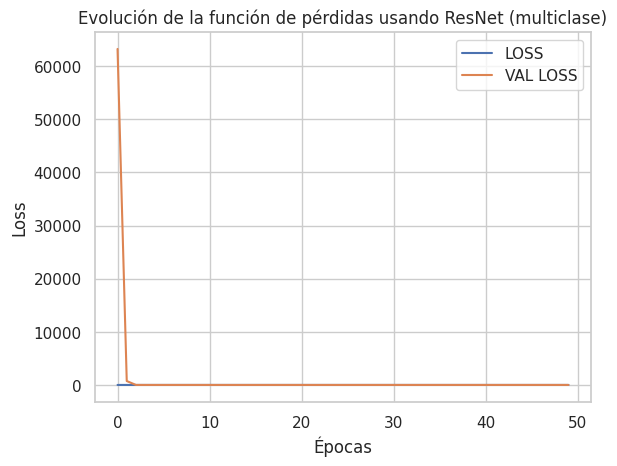

In [ ]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_resnet_multiclass.history['loss'],label="LOSS")
plt.plot(hist_resnet_multiclass.history['val_loss'],label="VAL LOSS")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando ResNet (multiclase)')
plt.legend()

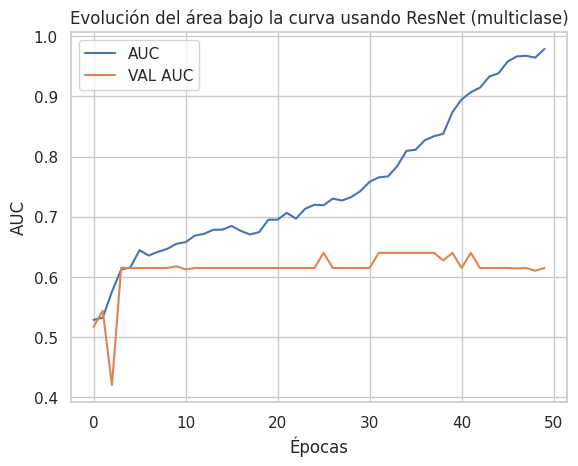

In [ ]:
# Ploteamos la evolucion de la métrica durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_resnet_multiclass.history['auc_9'],label="AUC")
plt.plot(hist_resnet_multiclass.history['val_auc_9'],label="VAL AUC")
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.title('Evolución del área bajo la curva usando ResNet (multiclase)')
plt.legend()

###PREDICCIONES

In [ ]:
predicciones_resnet_multiclass = model_resnet_multiclass.predict(X_test_multiclass)

8/8 [==============================] - 5s 513ms/step


###RESULTADOS

####CLASSIFICATION REPORT

In [ ]:
predicciones_binarias_resnet_multiclass, fpr_multiclass_resnet, tpr_multiclass_resnet = ClassificationReport(4,
                                                                                                             predicciones_resnet_multiclass,
                                                                                                             Y_test_multiclass,
                                                                                                             "multiclass",
                                                                                                             nombre_clase = df_labels.columns[[1,2,3,4]].tolist())

Área bajo la curva de la clase COPD_signs : 0.4855496616059996
UMBRAL: 0.08063818
cr: 
               precision    recall  f1-score   support

           0       0.50      0.01      0.01       154
           1       0.31      0.99      0.48        71

    accuracy                           0.32       225
   macro avg       0.41      0.50      0.24       225
weighted avg       0.44      0.32      0.16       225

Área bajo la curva de la clase heart_insufficiency : 0.49764150943396224
UMBRAL: 0.010280773
cr: 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       212
           1       0.00      0.00      0.00        13

    accuracy                           0.93       225
   macro avg       0.47      0.49      0.48       225
weighted avg       0.89      0.93      0.91       225

Área bajo la curva de la clase normal : 0.49956649904629796
UMBRAL: 0.18489169
cr: 
               precision    recall  f1-score   support

           0       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####CURVA ROC

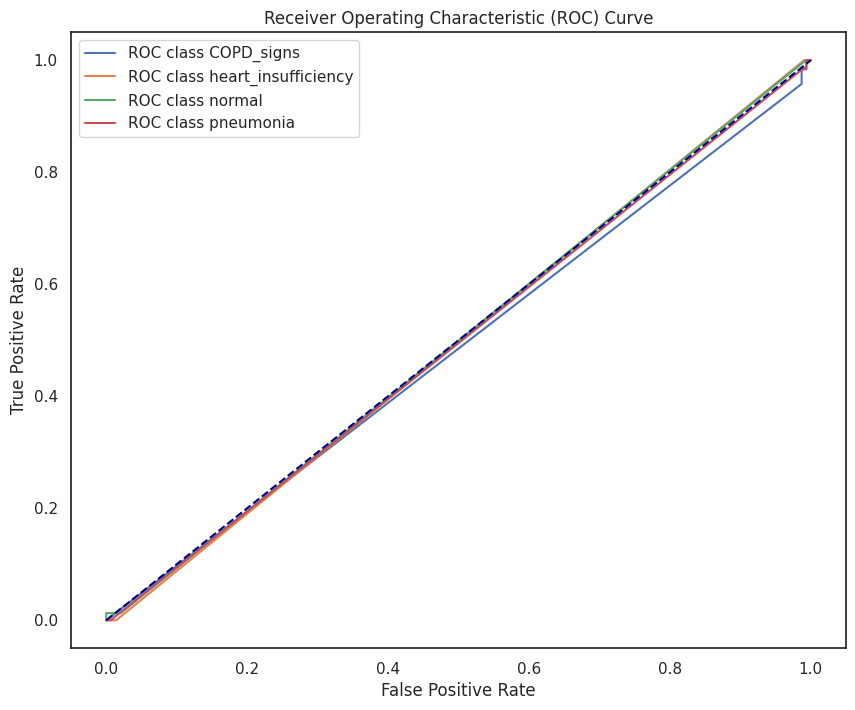

In [ ]:
plot_roc_curve(fpr_multiclass_resnet,
               tpr_multiclass_resnet,
               4,
               problem_type = "multiclass",
               nombre_clase = df_labels.columns[[1,2,3,4]].tolist())

####MATRIZ DE CONFUSIÓN

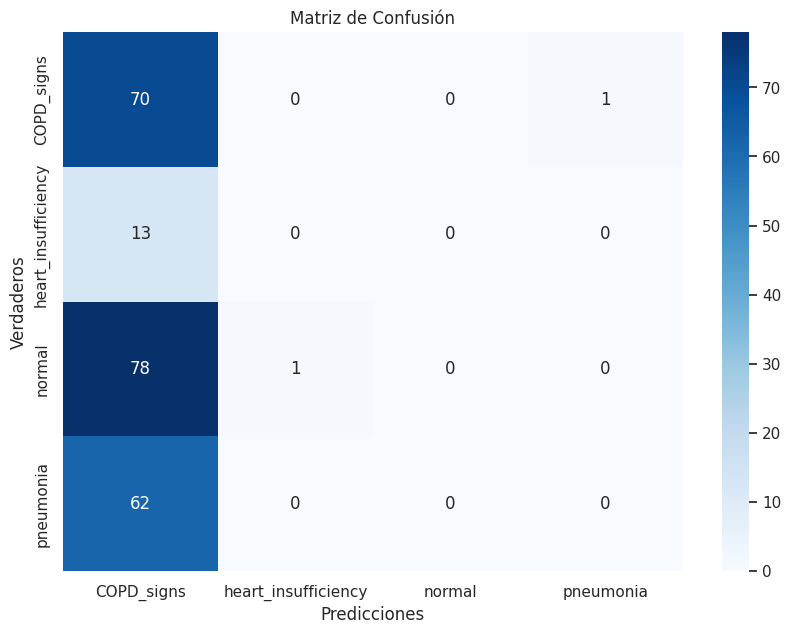

In [ ]:
ConfusionMatrix(4,
                Y_test_multiclass,
                np.array(predicciones_binarias_resnet_multiclass).T,
                problem_type = "multiclass",
                nombre_clase = df_labels.columns[[1,2,3,4]].tolist())

# ENFOQUE 3: ENFERMEDAD_i - NO ENFERMO

## CXR FOUNDATION

### SEPARAR EN ENTRENAMIENTO, VALIDACIÓN Y TEST

In [ ]:
from sklearn.model_selection import train_test_split
df_train_COPD, df_validate_COPD = train_test_split(df_labels.iloc[:,[1,5,6,7]], test_size=0.15, random_state= 42)
df_train_INS, df_validate_INS = train_test_split(df_labels.iloc[:,[2,5,6,7]], test_size=0.15, random_state= 42)
df_train_PNE, df_validate_PNE = train_test_split(df_labels.iloc[:,[4,5,6,7]], test_size=0.15, random_state= 42)

###ELECCIÓN ÓPTIMA DE HIPERPARÁMETROS

In [ ]:
from cxr_foundation import embeddings_data
# Create training and validation Datasets
training_data_COPD = embeddings_data.get_dataset(
    filenames=df_train_COPD["embedding_file"].values,
    labels=df_train_COPD.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)


validation_data_COPD = embeddings_data.get_dataset(
    filenames=df_validate_COPD["embedding_file"].values,
    labels=df_validate_COPD.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)

# Create and train the model
model_COPD = create_model(
    pd.DataFrame(df_train_COPD.iloc[:, 0]).columns.tolist(),
    token_num=TOKEN_NUM,
    embeddings_size = EMBEDDINGS_SIZE)

In [ ]:
# Create training and validation Datasets
training_data_INS = embeddings_data.get_dataset(
    filenames=df_train_INS["embedding_file"].values,
    labels=df_train_INS.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)


validation_data_INS = embeddings_data.get_dataset(
    filenames=df_validate_INS["embedding_file"].values,
    labels=df_validate_INS.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)

# Create and train the model
model_INS = create_model(
    pd.DataFrame(df_train_INS.iloc[:, 0]).columns.tolist(),
    token_num=TOKEN_NUM,
    embeddings_size = EMBEDDINGS_SIZE)

In [ ]:
# Create training and validation Datasets
training_data_PNE = embeddings_data.get_dataset(
    filenames=df_train_PNE["embedding_file"].values,
    labels=df_train_PNE.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)


validation_data_PNE = embeddings_data.get_dataset(
    filenames=df_validate_PNE["embedding_file"].values,
    labels=df_validate_PNE.iloc[:, 0].values,
    embeddings_size=TOKEN_NUM * EMBEDDINGS_SIZE)

# Create and train the model
model_PNE = create_model(
    pd.DataFrame(df_train_PNE.iloc[:, 0]).columns.tolist(),
    token_num=TOKEN_NUM,
    embeddings_size = EMBEDDINGS_SIZE)

###ENTRENAMIENTO

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
Y_train = df_train_COPD.iloc[:, 0]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}
hist_cxr_COPD = model_COPD.fit(
    x=training_data_COPD.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data_COPD.batch(1).cache(),
    epochs=500,
    #callbacks = early_stopping,
    shuffle = True,
    class_weight = class_weights_dict
)

Epoch 1/500
3/3 [==============================] - 1s 302ms/step - loss: 18.3784 - false_positives_12: 314.1873 - false_negatives_12: 198.7868 - true_positives_12: 437.7133 - true_negatives_12: 322.3128 - auc_12: 0.6357 - auc_pr: 0.6192 - val_loss: 18.6747 - val_false_positives_12: 151.0000 - val_false_negatives_12: 2.0000 - val_true_positives_12: 69.0000 - val_true_negatives_12: 3.0000 - val_auc_12: 0.5080 - val_auc_pr: 0.3372
Epoch 2/500
3/3 [==============================] - 0s 220ms/step - loss: 18.3593 - false_positives_12: 297.9362 - false_negatives_12: 193.0526 - true_positives_12: 443.4474 - true_negatives_12: 338.5638 - auc_12: 0.6529 - auc_pr: 0.6165 - val_loss: 18.6677 - val_false_positives_12: 151.0000 - val_false_negatives_12: 3.0000 - val_true_positives_12: 68.0000 - val_true_negatives_12: 3.0000 - val_auc_12: 0.5097 - val_auc_pr: 0.3382
Epoch 3/500
3/3 [==============================] - 0s 217ms/step - loss: 18.3749 - false_positives_12: 314.8644 - false_negatives_12: 21

In [ ]:
Y_train = df_train_INS.iloc[:, 0]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}
hist_cxr_INS = model_INS.fit(
    x=training_data_INS.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data_INS.batch(1).cache(),
    epochs=500,
    #callbacks = early_stopping,
    shuffle = True,
    class_weight = class_weights_dict
)

Epoch 1/500
3/3 [==============================] - 5s 583ms/step - loss: 18.9744 - false_positives_13: 319.8989 - false_negatives_13: 354.2261 - true_positives_13: 282.2739 - true_negatives_13: 316.6010 - auc_13: 0.4462 - auc_pr: 0.4707 - val_loss: 19.5584 - val_false_positives_13: 212.0000 - val_false_negatives_13: 0.0000e+00 - val_true_positives_13: 13.0000 - val_true_negatives_13: 0.0000e+00 - val_auc_13: 0.6319 - val_auc_pr: 0.0744
Epoch 2/500
3/3 [==============================] - 0s 214ms/step - loss: 18.8846 - false_positives_13: 320.4486 - false_negatives_13: 298.8782 - true_positives_13: 337.6217 - true_negatives_13: 316.0514 - auc_13: 0.5033 - auc_pr: 0.4980 - val_loss: 19.5368 - val_false_positives_13: 212.0000 - val_false_negatives_13: 0.0000e+00 - val_true_positives_13: 13.0000 - val_true_negatives_13: 0.0000e+00 - val_auc_13: 0.6265 - val_auc_pr: 0.0730
Epoch 3/500
3/3 [==============================] - 0s 215ms/step - loss: 18.8934 - false_positives_13: 320.4486 - false_

In [ ]:
Y_train = df_train_PNE.iloc[:, 0]
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}
hist_cxr_PNE = model_PNE.fit(
    x=training_data_PNE.batch(512).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data_PNE.batch(1).cache(),
    epochs=500,
    #callbacks = early_stopping,
    shuffle = True,
    class_weight = class_weights_dict
)

Epoch 1/500
3/3 [==============================] - 4s 579ms/step - loss: 18.8574 - false_positives_14: 308.3759 - false_negatives_14: 295.5701 - true_positives_14: 340.9299 - true_negatives_14: 328.1241 - auc_14: 0.5411 - auc_pr: 0.5447 - val_loss: 19.0421 - val_false_positives_14: 163.0000 - val_false_negatives_14: 0.0000e+00 - val_true_positives_14: 62.0000 - val_true_negatives_14: 0.0000e+00 - val_auc_14: 0.6781 - val_auc_pr: 0.4468
Epoch 2/500
3/3 [==============================] - 0s 221ms/step - loss: 18.9343 - false_positives_14: 309.8950 - false_negatives_14: 314.5919 - true_positives_14: 321.9081 - true_negatives_14: 326.6050 - auc_14: 0.5043 - auc_pr: 0.5162 - val_loss: 19.0372 - val_false_positives_14: 163.0000 - val_false_negatives_14: 0.0000e+00 - val_true_positives_14: 62.0000 - val_true_negatives_14: 0.0000e+00 - val_auc_14: 0.6818 - val_auc_pr: 0.4534
Epoch 3/500
3/3 [==============================] - 0s 216ms/step - loss: 18.8715 - false_positives_14: 294.7040 - false_

###CURVAS DE APRENDIZAJE

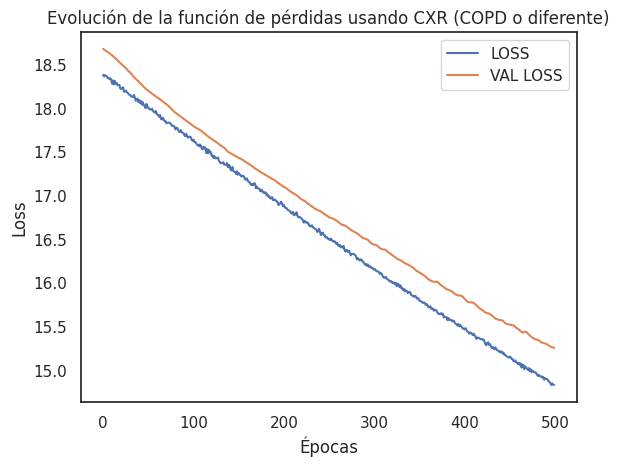

In [ ]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt
#%matplotlib inline

plt.figure()
plt.plot(hist_cxr_COPD.history['loss'],label="LOSS")
plt.plot(hist_cxr_COPD.history['val_loss'],label="VAL LOSS")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando CXR (COPD o diferente)')

plt.legend()

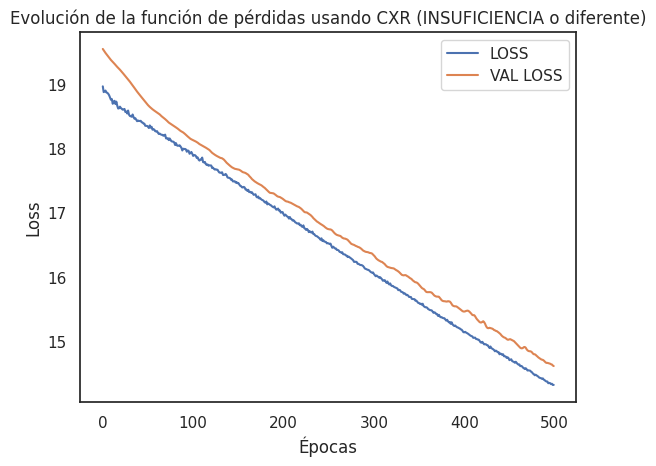

In [ ]:
# Ploteamos la evolucion del loss durante el entrenamiento
#%matplotlib inline

plt.figure()
plt.plot(hist_cxr_INS.history['loss'],label="LOSS")
plt.plot(hist_cxr_INS.history['val_loss'],label="VAL LOSS")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando CXR (INSUFICIENCIA o diferente)')
plt.legend()

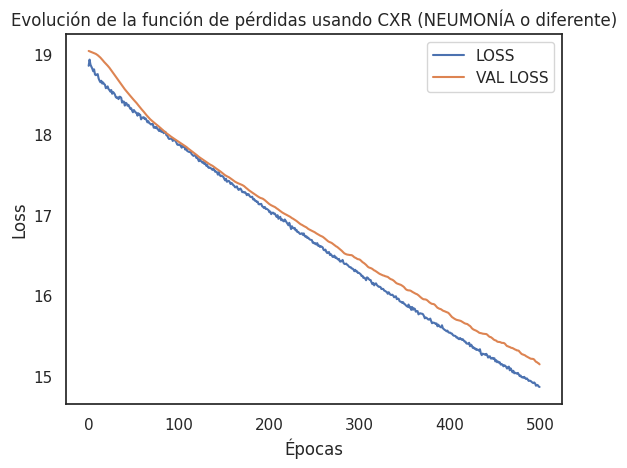

In [ ]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure()
plt.plot(hist_cxr_PNE.history['loss'],label="LOSS")
plt.plot(hist_cxr_PNE.history['val_loss'],label="VAL LOSS")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando CXR (NEUMONÍA o diferente)')
plt.legend()

In [ ]:
hist_cxr_COPD.history.keys()

dict_keys(['loss', 'false_positives_12', 'false_negatives_12', 'true_positives_12', 'true_negatives_12', 'auc_12', 'auc_pr', 'val_loss', 'val_false_positives_12', 'val_false_negatives_12', 'val_true_positives_12', 'val_true_negatives_12', 'val_auc_12', 'val_auc_pr'])

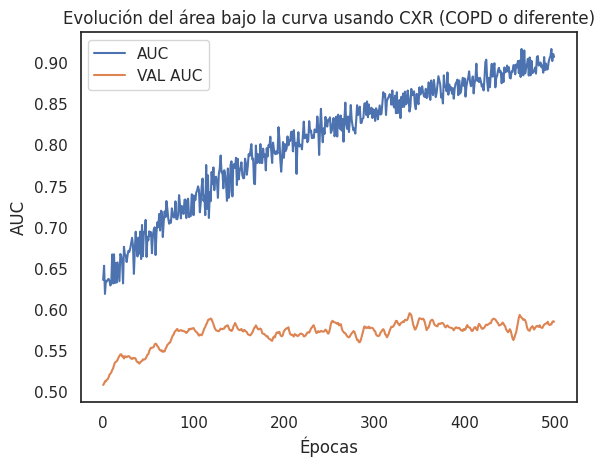

In [ ]:
plt.figure()
plt.plot(hist_cxr_COPD.history['auc_12'],label="AUC")
plt.plot(hist_cxr_COPD.history['val_auc_12'],label="VAL AUC")
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.title('Evolución del área bajo la curva usando CXR (COPD o diferente)')
plt.legend()

In [ ]:
hist_cxr_INS.history.keys()

dict_keys(['loss', 'false_positives_13', 'false_negatives_13', 'true_positives_13', 'true_negatives_13', 'auc_13', 'auc_pr', 'val_loss', 'val_false_positives_13', 'val_false_negatives_13', 'val_true_positives_13', 'val_true_negatives_13', 'val_auc_13', 'val_auc_pr'])

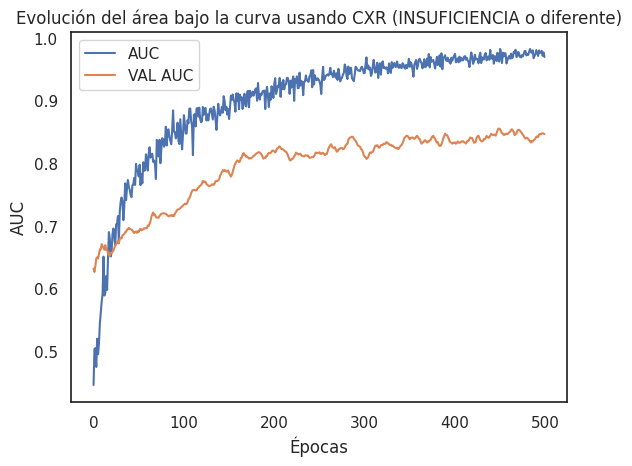

In [ ]:
# Ploteamos la evolucion de la métrica durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure
plt.plot(hist_cxr_INS.history['auc_13'],label="AUC")
plt.plot(hist_cxr_INS.history['val_auc_13'],label="VAL AUC")
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.title('Evolución del área bajo la curva usando CXR (INSUFICIENCIA o diferente)')
plt.legend()

In [ ]:
hist_cxr_PNE.history.keys()

dict_keys(['loss', 'false_positives_14', 'false_negatives_14', 'true_positives_14', 'true_negatives_14', 'auc_14', 'auc_pr', 'val_loss', 'val_false_positives_14', 'val_false_negatives_14', 'val_true_positives_14', 'val_true_negatives_14', 'val_auc_14', 'val_auc_pr'])

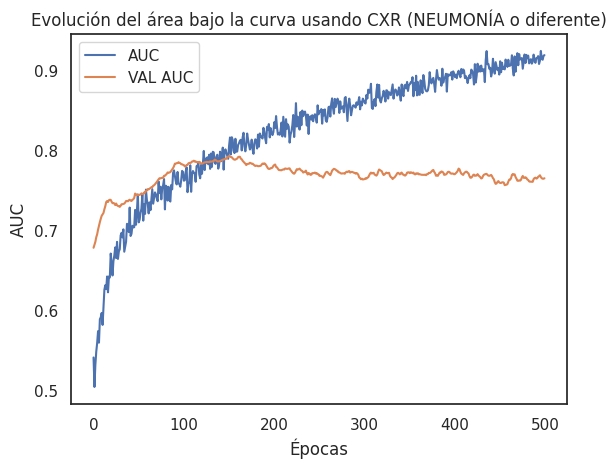

In [ ]:
# Ploteamos la evolucion de la métrica durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure
plt.plot(hist_cxr_PNE.history['auc_14'],label="AUC")
plt.plot(hist_cxr_PNE.history['val_auc_14'],label="VAL AUC")
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.title('Evolución del área bajo la curva usando CXR (NEUMONÍA o diferente)')
plt.legend()

###PREDICCIONES

In [ ]:
predicciones_cxr_COPD = model_COPD.predict(validation_data_COPD.batch(1).cache())

225/225 [==============================] - 1s 2ms/step


In [ ]:
predicciones_cxr_INS = model_INS.predict(validation_data_INS.batch(1).cache())

225/225 [==============================] - 1s 2ms/step


In [ ]:
predicciones_cxr_PNE = model_PNE.predict(validation_data_PNE.batch(1).cache())

225/225 [==============================] - 0s 2ms/step


### RESULTADOS

####CLASSIFICATION REPORT

In [ ]:
predicciones_binarias_COPD, fpr_COPD, tpr_COPD = ClassificationReport(1,
                                                                      predicciones_cxr_COPD,
                                                                      df_validate_COPD.iloc[:, 0].values,
                                                                      "binary",
                                                                       ["COPD SIGNS"])

Área bajo la curva de la clase  COPD SIGNS : 0.5849643314432047
UMBRAL: 0.5513534
cr: 
               precision    recall  f1-score   support

           0       0.80      0.57      0.67       154
           1       0.43      0.69      0.53        71

    accuracy                           0.61       225
   macro avg       0.61      0.63      0.60       225
weighted avg       0.68      0.61      0.62       225



In [ ]:
predicciones_binarias_INS, fpr_INS, tpr_INS = ClassificationReport(1,
                                                                   predicciones_cxr_INS,
                                                                   df_validate_INS.iloc[:, 0].values,
                                                                   "binary",
                                                                    ["HEART INSUFFICIENCY"])

Área bajo la curva de la clase  HEART INSUFFICIENCY : 0.8468795355587808
UMBRAL: 0.55581295
cr: 
               precision    recall  f1-score   support

           0       0.99      0.73      0.84       212
           1       0.16      0.85      0.27        13

    accuracy                           0.74       225
   macro avg       0.57      0.79      0.56       225
weighted avg       0.94      0.74      0.81       225



In [ ]:
predicciones_binarias_PNE, fpr_PNE, tpr_PNE = ClassificationReport(1,
                                                                   predicciones_cxr_PNE,
                                                                   df_validate_PNE.iloc[:, 0].values,
                                                                   "binary",
                                                                   ["PNEUMONIA"])

Área bajo la curva de la clase  PNEUMONIA : 0.765188996635662
UMBRAL: 0.51734483
cr: 
               precision    recall  f1-score   support

           0       0.87      0.69      0.77       163
           1       0.47      0.73      0.57        62

    accuracy                           0.70       225
   macro avg       0.67      0.71      0.67       225
weighted avg       0.76      0.70      0.71       225



#### CURVA ROC


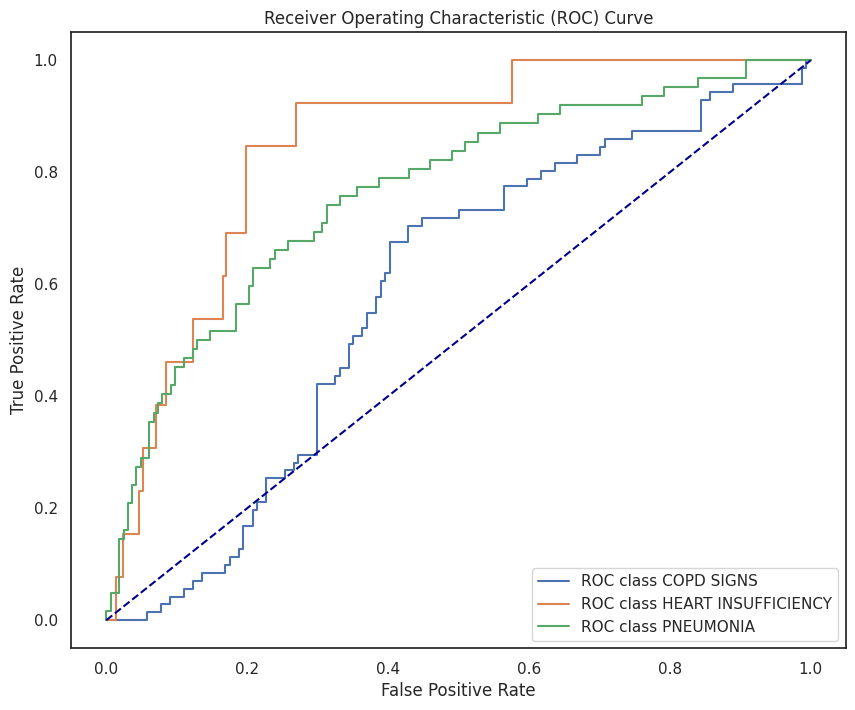

In [ ]:
sns.set(style="white")
plt.figure(figsize=(10, 8))

for i in range(len(fpr_COPD)):
  plt.plot(fpr_COPD[i], tpr_COPD[i], label='ROC class COPD SIGNS')
  plt.plot(fpr_INS[i], tpr_INS[i], label='ROC class HEART INSUFFICIENCY')
  plt.plot(fpr_PNE[i], tpr_PNE[i], label='ROC class PNEUMONIA')
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(False)
plt.show()

####MATRIZ DE CONFUSIÓN

In [ ]:

def ConfusionMatrix1(n_classes, Y_test, predicciones_binarias_lista, nombre_clase, problem_type):

    # Configuración de seaborn para mejores gráficos
  sns.set(style="whitegrid")
  # Crear subplots para cada matriz de confusión
  fig, ax = plt.subplots() # 2 filas, 3 columnas
  if problem_type == "binary":
    confusion_matrices = []
    for i in range(n_classes):
        cm = confusion_matrix(Y_test[:,i], predicciones_binarias_lista[:,i])
        confusion_matrices.append(cm)

        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax)
        ax.set_title(f'Clase {nombre_clase[i]}')
        ax.set_xlabel('Predicho')
        ax.set_ylabel('Verdadero')

    plt.tight_layout()
    plt.show()


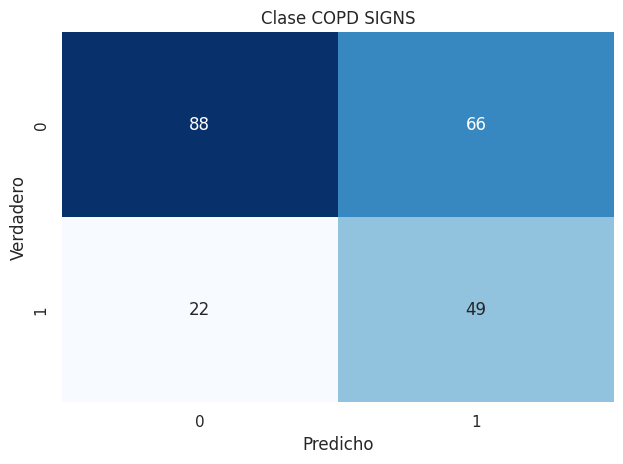

In [ ]:

ConfusionMatrix(1,
                df_validate_COPD.iloc[:, 0].values.reshape(-1,1),
                np.array(predicciones_binarias_COPD).T.reshape(-1,1),
                ["COPD SIGNS"],
                "binary")


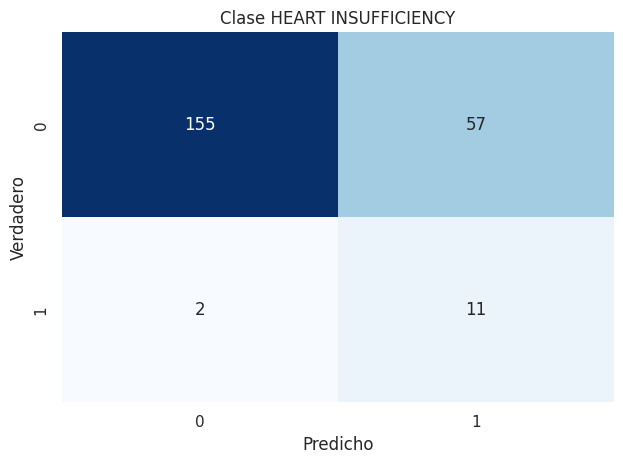

In [ ]:
ConfusionMatrix(1,
                df_validate_INS.iloc[:, 0].values.reshape(-1,1),
                np.array(predicciones_binarias_INS).T.reshape(-1,1),
                ["HEART INSUFFICIENCY"],
                "binary")

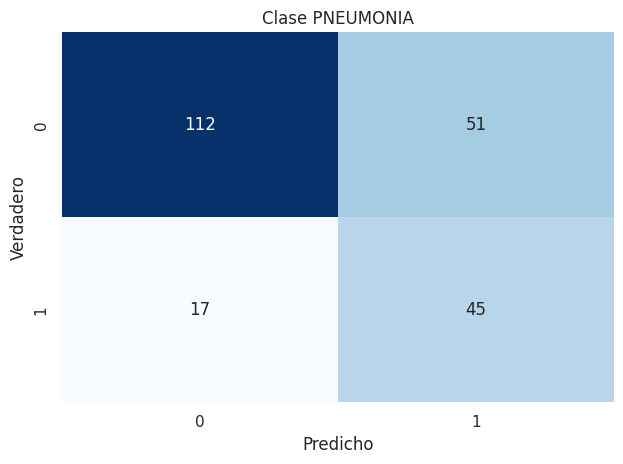

In [ ]:
ConfusionMatrix(1,
                df_validate_PNE.iloc[:, 0].values.reshape(-1,1),
                np.array(predicciones_binarias_PNE).T.reshape(-1,1),
                 ["PNEUMONIA"],
                "binary")

In [220]:
import numpy as np

# Concatenar las predicciones de los tres modelos en un solo array
probabilities = np.concatenate((predicciones_cxr_COPD, predicciones_cxr_INS, predicciones_cxr_PNE), axis=1)

# Umbral para cada clase
thresholds = [0.7379165, 0.4519251, 0.755726]
thresolds = [0.5513534, 0.55581295, 0.51734483]
# Definición de clases
class_copd = 0
class_ins = 1
class_normal = 2
class_pne = 3

# Lista para almacenar las predicciones del ensemble
predicciones_cxr_ensemble = []

# Iterar sobre cada conjunto de probabilidades
for i in range(probabilities.shape[0]):
    votes = [0, 0, 0]  # COPD, INS, PNE

    # Contar votos para cada clase si la probabilidad supera el umbral
    for j in range(3):
        if probabilities[i, j] > thresholds[j]:
            votes[j] += 1

    if max(votes) == 0:
        # Si no hay votos que superen los umbrales, asignar clase normal
        predicciones_cxr_ensemble.append(class_normal)
    else:
        # Elegir la clase con más votos
        max_votes = max(votes)
        candidates = [index for index, value in enumerate(votes) if value == max_votes]
        if len(candidates) > 1:
            # Empate: seleccionar la clase cuya diferencia entre la probabilidad y el umbral sea mayor
            max_diff_index = candidates[np.argmax([probabilities[i, idx] - thresholds[idx] for idx in candidates])]
            predicciones_cxr_ensemble.append([class_copd, class_ins, class_pne][max_diff_index])
        else:
            # Sin empate: asignar la clase directamente
            predicciones_cxr_ensemble.append([class_copd, class_ins, class_pne][candidates[0]])

# Imprimir o retornar las predicciones del ensemble
print(predicciones_cxr_ensemble)
# return predicciones_cxr_ensemble  # Descomentar si se desea retornar en una función


[1, 1, 3, 3, 2, 1, 1, 2, 2, 2, 1, 0, 1, 3, 1, 3, 2, 0, 1, 1, 2, 2, 2, 1, 1, 3, 2, 3, 0, 2, 0, 2, 2, 2, 3, 0, 1, 1, 1, 3, 0, 2, 0, 1, 2, 2, 2, 2, 1, 0, 2, 3, 3, 1, 0, 2, 2, 0, 2, 1, 3, 3, 1, 2, 3, 3, 0, 1, 2, 2, 2, 0, 0, 3, 3, 1, 1, 1, 0, 3, 1, 1, 3, 1, 1, 3, 2, 0, 2, 2, 2, 3, 1, 3, 1, 3, 3, 3, 3, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 3, 3, 1, 0, 1, 2, 2, 0, 2, 1, 0, 2, 3, 1, 1, 2, 1, 1, 3, 0, 3, 1, 1, 2, 2, 0, 1, 2, 1, 2, 0, 1, 3, 1, 0, 3, 0, 1, 0, 0, 0, 0, 3, 1, 1, 2, 3, 1, 2, 0, 1, 2, 2, 3, 0, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 1, 1, 3, 2, 1, 1, 2, 2, 0, 3, 1, 1, 3, 1, 2, 0, 1, 2, 1, 1, 0, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2]


In [209]:
test = np.concatenate((df_validate_COPD.iloc[:, 0].values.reshape(-1,1),
                df_validate_INS.iloc[:, 0].values.reshape(-1,1),
                df_validate_PNE.iloc[:, 0].values.reshape(-1,1)), axis = 1)

In [210]:
test = np.concatenate((df_validate_COPD.iloc[:, 0].values.reshape(-1,1),
                df_validate_INS.iloc[:, 0].values.reshape(-1,1),
                df_validate_PNE.iloc[:, 0].values.reshape(-1,1)), axis = 1)


# Crear una nueva columna para insertar
new_column = np.zeros((test.shape[0], 1), dtype=int)

# Encontrar filas donde todos los valores son cero
mask = (test == 0).all(axis=1).reshape(-1,1)

new_column[mask] = 1
new_column.reshape(-1,1)
test_final = np.insert(test, 2, new_column.flatten(), axis=1)
test_final = np.argmax(test_final, axis = 1)

In [211]:
new_column[mask] = 1

In [212]:
new_column.reshape(-1,1)

(225, 1)

In [213]:
test_final = np.insert(test, 2, new_column.flatten(), axis=1)

In [219]:
test_final = np.argmax(test_final, axis = 1)

array([2, 2, 3, 3, 0, 3, 1, 0, 2, 3, 0, 2, 1, 3, 2, 0, 3, 0, 3, 2, 2, 2,
       2, 2, 0, 3, 3, 2, 0, 3, 2, 2, 3, 0, 3, 3, 2, 0, 0, 3, 2, 2, 3, 0,
       2, 3, 0, 2, 2, 2, 3, 0, 1, 3, 1, 0, 2, 2, 3, 0, 0, 3, 0, 3, 3, 3,
       0, 3, 3, 2, 3, 0, 0, 3, 3, 2, 2, 0, 2, 0, 2, 1, 3, 0, 0, 3, 2, 2,
       2, 2, 2, 3, 0, 2, 2, 2, 3, 3, 0, 0, 0, 2, 2, 0, 2, 3, 2, 3, 0, 3,
       2, 0, 2, 0, 1, 2, 3, 0, 3, 0, 3, 3, 0, 3, 0, 2, 0, 0, 2, 0, 3, 0,
       0, 2, 0, 0, 0, 2, 0, 3, 0, 2, 0, 2, 0, 2, 0, 3, 0, 2, 3, 1, 3, 2,
       2, 0, 2, 0, 3, 2, 0, 3, 2, 0, 3, 0, 2, 3, 3, 0, 2, 3, 2, 2, 3, 2,
       3, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 3, 3, 0, 0, 0, 1, 3, 2, 0, 3,
       0, 2, 0, 2, 3, 2, 0, 1, 3, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 3,
       1, 3, 2, 1, 0])

In [52]:

def ConfusionMatrixEnsemble(n_classes, Y_test, etiquetas_finales, nombre_clase, problem_type):

  if problem_type == "multiclass":

    cm = confusion_matrix(Y_test,etiquetas_finales)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=nombre_clase, yticklabels=nombre_clase)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predicciones')
    plt.title('Matriz de Confusión')
    plt.show()

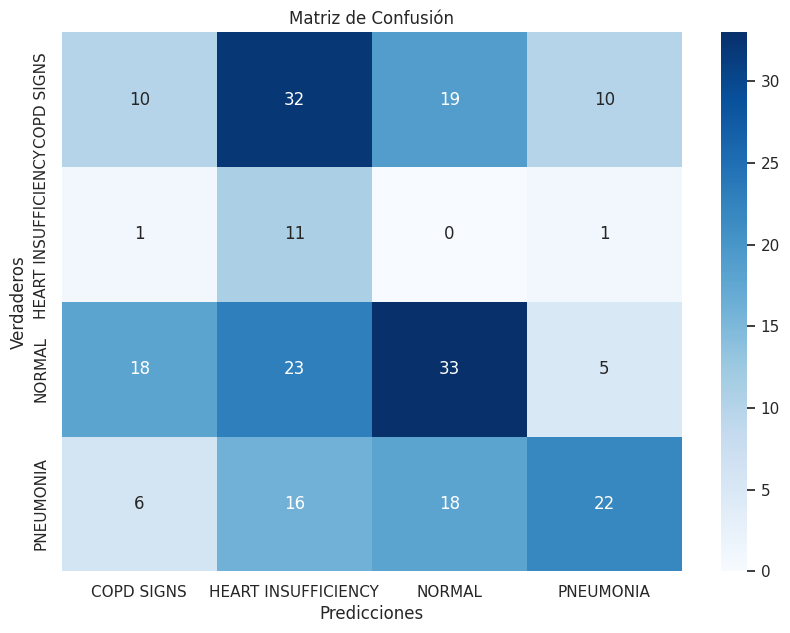

In [224]:
ConfusionMatrixEnsemble(4,
                        np.argmax(test_final, axis = 1),
                        predicciones_cxr_ensemble,
                         ["COPD SIGNS","HEART INSUFFICIENCY","NORMAL","PNEUMONIA"],
                        "multiclass")

## RESNET

###SEPARAR EN ENTRENAMIENTO, VALIDACIÓN Y TEST

In [23]:
from sklearn.model_selection import train_test_split
X_train_COPD, X_test_COPD, Y_train_COPD, Y_test_COPD = train_test_split(data, df_labels["COPD_signs"], test_size=0.15, random_state=42)
X_train_INS, X_test_INS, Y_train_INS, Y_test_INS = train_test_split(data, df_labels["heart_insufficiency"], test_size=0.15, random_state=42)
X_train_PNE, X_test_PNE, Y_train_PNE, Y_test_PNE = train_test_split(data, df_labels["pneumonia"], test_size=0.15, random_state=42)

In [24]:
X_train_COPD = np.array(X_train_COPD)
X_train_INS = np.array(X_train_INS)
X_train_PNE = np.array(X_train_PNE)


X_test_COPD = np.array(X_test_COPD)
X_test_INS = np.array(X_test_INS)
X_test_PNE = np.array(X_test_PNE)

Y_train_COPD = np.array(Y_train_COPD)
Y_train_INS = np.array(Y_train_INS)
Y_train_PNE = np.array(Y_train_PNE)

Y_test_COPD = np.array(Y_test_COPD)
Y_test_INS = np.array(Y_test_INS)
Y_test_PNE = np.array(Y_test_PNE)

###DEFINIR MODELO

Partiendo del modelo base, definimos de nuevo la capa de salida, que será igual para las 3 clases

In [25]:
x = model_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)


x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
X = Dropout(0.2)(x)

predictions = Dense(1, activation='sigmoid')(x)

Definimos 3 modelos iguales, cada uno se entrenará para clasificar 1 enfermedad.

In [26]:
model_resnet_COPD = Model(inputs=model_base.input, outputs=predictions)
model_resnet_INS = Model(inputs=model_base.input, outputs=predictions)
model_resnet_PNE = Model(inputs=model_base.input, outputs=predictions)

###ELECCIÓN ÓPTIMA DE HIPERPARÁMETROS

In [31]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

optimizador = Adam(learning_rate = 1e-3, weight_decay = 0.01)

model_resnet_COPD.compile(optimizer = optimizador,
              loss='binary_crossentropy',
              weighted_metrics=[
                  tf.keras.metrics.FalsePositives(),
                  tf.keras.metrics.FalseNegatives(),
                  tf.keras.metrics.TruePositives(),
                  tf.keras.metrics.TrueNegatives(),
                  tf.keras.metrics.AUC(),
                  tf.keras.metrics.AUC(curve='PR', name='auc_pr')])

model_resnet_INS.compile(optimizer = optimizador,
              loss='binary_crossentropy',
              weighted_metrics=[
                  tf.keras.metrics.FalsePositives(),
                  tf.keras.metrics.FalseNegatives(),
                  tf.keras.metrics.TruePositives(),
                  tf.keras.metrics.TrueNegatives(),
                  tf.keras.metrics.AUC(),
                  tf.keras.metrics.AUC(curve='PR', name='auc_pr')])

model_resnet_PNE.compile(optimizer = optimizador,
              loss='binary_crossentropy',
              weighted_metrics=[
                  tf.keras.metrics.FalsePositives(),
                  tf.keras.metrics.FalseNegatives(),
                  tf.keras.metrics.TruePositives(),
                  tf.keras.metrics.TrueNegatives(),
                  tf.keras.metrics.AUC(),
                  tf.keras.metrics.AUC(curve='PR', name='auc_pr')])

###ENTRENAMIENTO

In [63]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train_COPD), y=Y_train_COPD)

class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}

hist_resnet_COPD = model_resnet_COPD.fit(X_train_COPD, Y_train_COPD,
                                         batch_size=128,
                                         epochs=50,
                                         validation_data=(X_test_COPD, Y_test_COPD),
                                         class_weight=class_weights_dict)


Epoch 1/50
10/10 [==============================] - 75s 7s/step - loss: 0.7300 - false_positives_3: 321.6357 - false_negatives_3: 305.8258 - true_positives_3: 330.6742 - true_negatives_3: 314.8644 - auc_3: 0.4927 - auc_pr: 0.4818 - val_loss: 4.5891 - val_false_positives_3: 0.0000e+00 - val_false_negatives_3: 71.0000 - val_true_positives_3: 0.0000e+00 - val_true_negatives_3: 154.0000 - val_auc_3: 0.5000 - val_auc_pr: 0.3156
Epoch 2/50
10/10 [==============================] - 74s 7s/step - loss: 0.7175 - false_positives_3: 322.9899 - false_negatives_3: 323.0285 - true_positives_3: 313.4715 - true_negatives_3: 313.5101 - auc_3: 0.5046 - auc_pr: 0.5105 - val_loss: 0.6388 - val_false_positives_3: 0.0000e+00 - val_false_negatives_3: 71.0000 - val_true_positives_3: 0.0000e+00 - val_true_negatives_3: 154.0000 - val_auc_3: 0.4675 - val_auc_pr: 0.3206
Epoch 3/50
10/10 [==============================] - 74s 7s/step - loss: 0.7037 - false_positives_3: 340.5952 - false_negatives_3: 282.8889 - true_

In [64]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train_INS), y=Y_train_INS)

class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}

hist_resnet_INS = model_resnet_INS.fit(X_train_INS, Y_train_INS,
                                       batch_size=128,
                                       epochs=50,
                                       validation_data=(X_test_INS, Y_test_INS),
                                       class_weight=class_weights_dict)



Epoch 1/50
10/10 [==============================] - 73s 7s/step - loss: 2.5462 - false_positives_4: 171.4922 - false_negatives_4: 581.1522 - true_positives_4: 55.3478 - true_negatives_4: 465.0078 - auc_4: 0.3626 - auc_pr: 0.3988 - val_loss: 0.6515 - val_false_positives_4: 89.0000 - val_false_negatives_4: 4.0000 - val_true_positives_4: 9.0000 - val_true_negatives_4: 123.0000 - val_auc_4: 0.6803 - val_auc_pr: 0.0956
Epoch 2/50
10/10 [==============================] - 73s 7s/step - loss: 0.7586 - false_positives_4: 96.1896 - false_negatives_4: 453.8522 - true_positives_4: 182.6478 - true_negatives_4: 540.3104 - auc_4: 0.5995 - auc_pr: 0.6016 - val_loss: 38.9962 - val_false_positives_4: 0.0000e+00 - val_false_negatives_4: 13.0000 - val_true_positives_4: 0.0000e+00 - val_true_negatives_4: 212.0000 - val_auc_4: 0.5000 - val_auc_pr: 0.0578
Epoch 3/50
10/10 [==============================] - 73s 7s/step - loss: 0.7145 - false_positives_4: 123.1226 - false_negatives_4: 459.3869 - true_positives

In [65]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train_PNE), y=Y_train_PNE)

class_weights_dict = {
    0: class_weights[0],  # Peso para la clase 0
    1: class_weights[1],  # Peso para la clase 1
}

hist_resnet_PNE = model_resnet_PNE.fit(X_train_PNE, Y_train_PNE,
                                       batch_size=128,
                                       epochs=50,
                                       validation_data=(X_test_PNE, Y_test_PNE),
                                       class_weight=class_weights_dict)


Epoch 1/50
10/10 [==============================] - 73s 7s/step - loss: 1.8422 - false_positives_5: 81.2715 - false_negatives_5: 620.4045 - true_positives_5: 16.0954 - true_negatives_5: 555.2285 - auc_5: 0.4335 - auc_pr: 0.4330 - val_loss: 0.6782 - val_false_positives_5: 10.0000 - val_false_negatives_5: 60.0000 - val_true_positives_5: 2.0000 - val_true_negatives_5: 153.0000 - val_auc_5: 0.5239 - val_auc_pr: 0.2980
Epoch 2/50
10/10 [==============================] - 73s 7s/step - loss: 1.0198 - false_positives_5: 6.8359 - false_negatives_5: 627.7206 - true_positives_5: 8.7793 - true_negatives_5: 629.6640 - auc_5: 0.5383 - auc_pr: 0.5431 - val_loss: 0.5992 - val_false_positives_5: 1.0000 - val_false_negatives_5: 62.0000 - val_true_positives_5: 0.0000e+00 - val_true_negatives_5: 162.0000 - val_auc_5: 0.5611 - val_auc_pr: 0.3000
Epoch 3/50
10/10 [==============================] - 73s 7s/step - loss: 0.8235 - false_positives_5: 0.7595 - false_negatives_5: 608.6989 - true_positives_5: 27.801

###CURVAS DE APRENDIZAJE

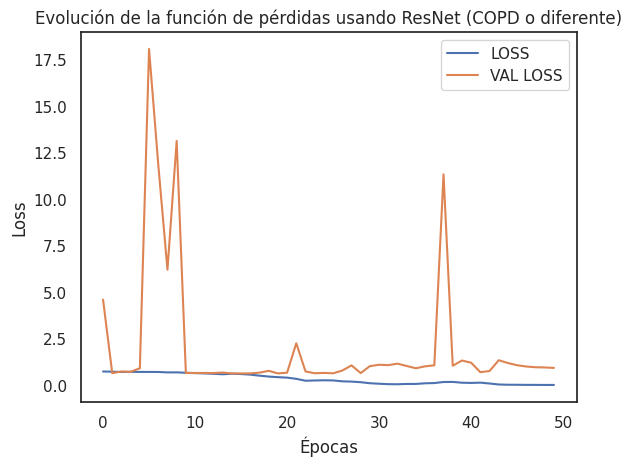

In [66]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure
plt.plot(hist_resnet_COPD.history['loss'],label="LOSS")
plt.plot(hist_resnet_COPD.history['val_loss'],label="VAL LOSS")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando ResNet (COPD o diferente)')
plt.legend()

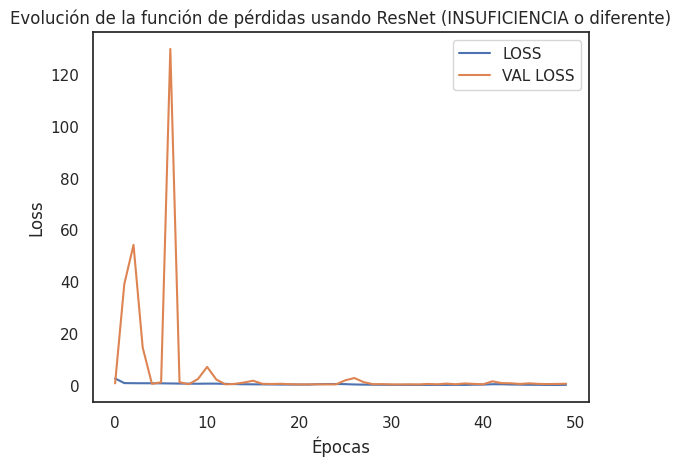

In [67]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure
plt.plot(hist_resnet_INS.history['loss'],label="LOSS")
plt.plot(hist_resnet_INS.history['val_loss'],label="VAL LOSS")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title('Evolución de la función de pérdidas usando ResNet (INSUFICIENCIA o diferente)')
plt.legend()

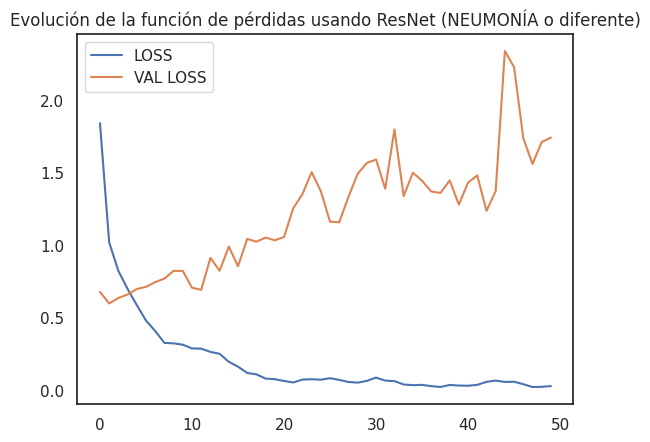

In [68]:
# Ploteamos la evolucion del loss durante el entrenamiento
import matplotlib.pyplot as plt

#%matplotlib inline

plt.figure
plt.plot(hist_resnet_PNE.history['loss'],label="LOSS")
plt.plot(hist_resnet_PNE.history['val_loss'],label="VAL LOSS")
plt.title('Evolución de la función de pérdidas usando ResNet (NEUMONÍA o diferente)')
plt.legend()

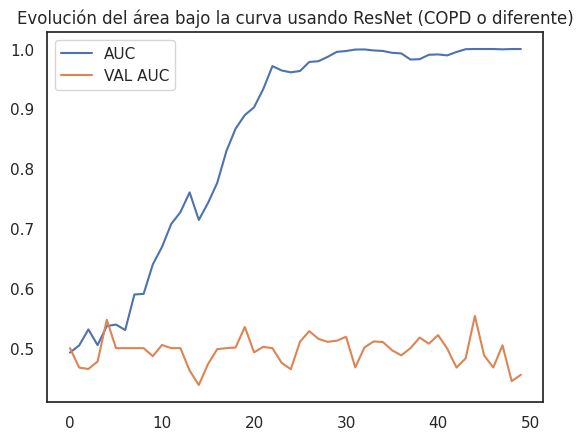

In [89]:
plt.figure()
plt.plot(hist_resnet_COPD.history['auc_3'],label="AUC")
plt.plot(hist_resnet_COPD.history['val_auc_3'],label="VAL AUC")
plt.title('Evolución del área bajo la curva usando ResNet (COPD o diferente)')
plt.legend()

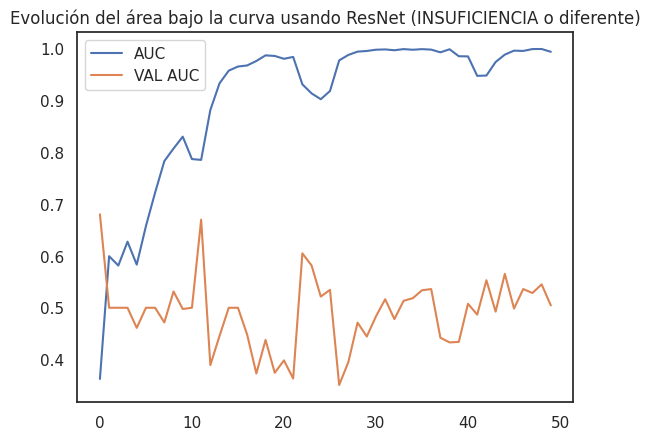

In [90]:
plt.figure()
plt.plot(hist_resnet_INS.history['auc_4'],label="AUC")
plt.plot(hist_resnet_INS.history['val_auc_4'],label="VAL AUC")
plt.title('Evolución del área bajo la curva usando ResNet (INSUFICIENCIA o diferente)')
plt.legend()

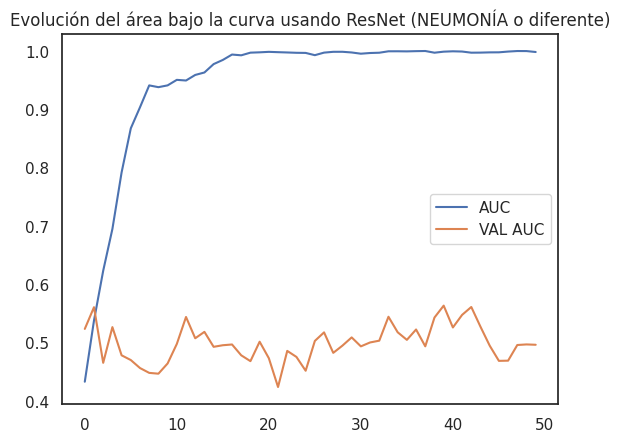

In [91]:
plt.figure()
plt.plot(hist_resnet_PNE.history['auc_5'],label="AUC")
plt.plot(hist_resnet_PNE.history['val_auc_5'],label="VAL AUC")
plt.title('Evolución del área bajo la curva usando ResNet (NEUMONÍA o diferente)')
plt.legend()

###PREDICCIONES

In [73]:
predicciones_resnet_COPD = model_resnet_COPD.predict(X_test_COPD)

8/8 [==============================] - 4s 450ms/step


In [74]:
predicciones_resnet_INS = model_resnet_INS.predict(X_test_INS)

8/8 [==============================] - 4s 535ms/step


In [75]:
predicciones_resnet_PNE = model_resnet_PNE.predict(X_test_PNE)

8/8 [==============================] - 4s 449ms/step


###RESULTADOS

####CLASSIFICATION REPORT

In [76]:
predicciones_binarias_resnet_COPD, fpr_binary_resnet_COPD, tpr_binary_resnet_COPD = ClassificationReport(1,
                                                                                                         predicciones_resnet_COPD,
                                                                                                         Y_test_COPD,
                                                                                                         "binary",
                                                                                                         ["COPD SIGNS"])

Área bajo la curva de la clase  COPD SIGNS : 0.521218218401317
UMBRAL: 0.013672445
cr: 
               precision    recall  f1-score   support

           0       0.76      0.46      0.57       154
           1       0.37      0.69      0.48        71

    accuracy                           0.53       225
   macro avg       0.57      0.58      0.53       225
weighted avg       0.64      0.53      0.55       225



In [77]:
predicciones_binarias_resnet_INS, fpr_binary_resnet_INS, tpr_binary_resnet_INS = ClassificationReport(1,
                                                                                                      predicciones_resnet_INS,
                                                                                                      Y_test_INS,
                                                                                                      "binary",
                                                                                                      ["HEART INSUFFICIENCY"])

Área bajo la curva de la clase  HEART INSUFFICIENCY : 0.4720609579100145
UMBRAL: 0.0031571246
cr: 
               precision    recall  f1-score   support

           0       0.94      0.08      0.14       212
           1       0.06      0.92      0.11        13

    accuracy                           0.12       225
   macro avg       0.50      0.50      0.12       225
weighted avg       0.89      0.12      0.14       225



In [78]:
predicciones_binarias_resnet_PNE, fpr_binary_resnet_PNE, tpr_binary_resnet_PNE = ClassificationReport(1,
                                                                                                      predicciones_resnet_PNE,
                                                                                                      Y_test_PNE,
                                                                                                      "binary",
                                                                                                      ["PNEUMONIA"])

Área bajo la curva de la clase  PNEUMONIA : 0.5035622402533149
UMBRAL: 0.29333004
cr: 
               precision    recall  f1-score   support

           0       0.74      0.68      0.71       163
           1       0.31      0.37      0.34        62

    accuracy                           0.60       225
   macro avg       0.52      0.53      0.52       225
weighted avg       0.62      0.60      0.61       225



####CURVA ROC

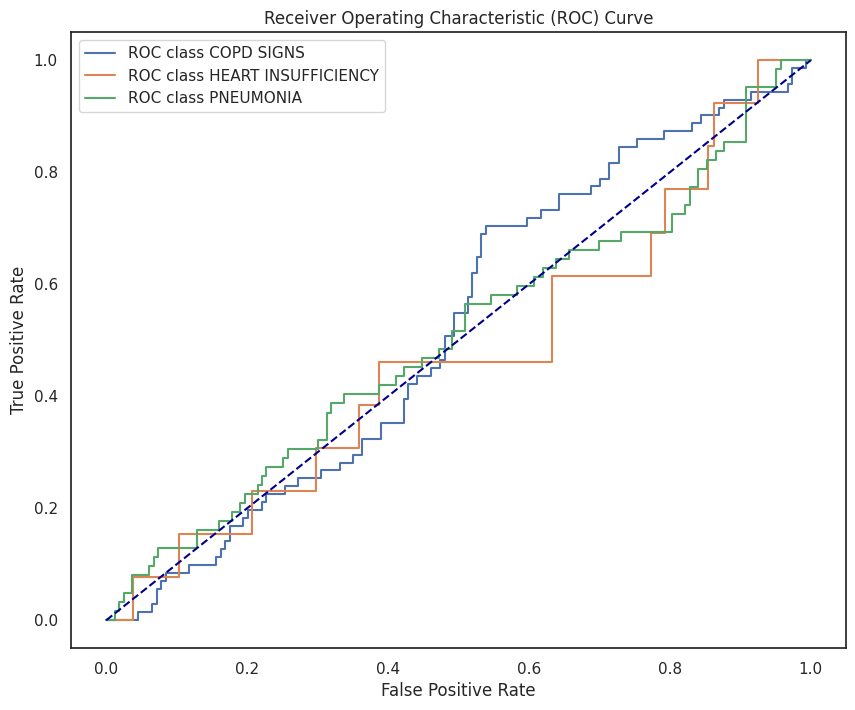

In [80]:
sns.set(style="white")
plt.figure(figsize=(10, 8))

for i in range(len(fpr_binary_resnet_COPD)):
  plt.plot(fpr_binary_resnet_COPD[i], tpr_binary_resnet_COPD[i], label='ROC class COPD SIGNS')
  plt.plot(fpr_binary_resnet_INS[i], tpr_binary_resnet_INS[i], label='ROC class HEART INSUFFICIENCY')
  plt.plot(fpr_binary_resnet_PNE[i], tpr_binary_resnet_PNE[i], label='ROC class PNEUMONIA')
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(False)
plt.show()

####MATRIZ DE CONFUSIÓN

In [94]:
def ConfusionMatrix(n_classes, Y_test, predicciones_binarias_lista, nombre_clase, problem_type):

  if problem_type == "binary":

    # Configuración de seaborn para mejores gráficos
    sns.set(style="whitegrid")
    # Crear subplots para cada matriz de confusión
    fig, ax = plt.subplots()


    confusion_matrices = []
    for i in range(n_classes):
        cm = confusion_matrix(Y_test[:,i], predicciones_binarias_lista[:,i])
        confusion_matrices.append(cm)

        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cbar=False, cmap='Blues', ax=ax)
        ax.set_title(f'Clase {nombre_clase[i]}')
        ax.set_xlabel('Predicho')
        ax.set_ylabel('Verdadero')

    plt.tight_layout()
    plt.show()


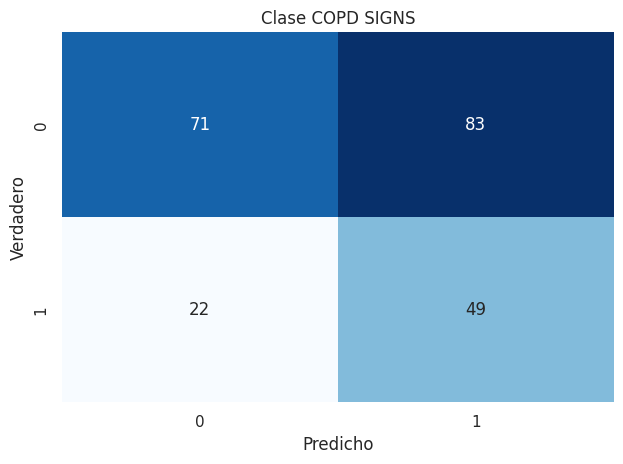

In [96]:
ConfusionMatrix(1,
                Y_test_COPD.reshape(-1,1),
                np.array(predicciones_binarias_resnet_COPD).T.reshape(-1,1),
                ["COPD SIGNS"],
                "binary")

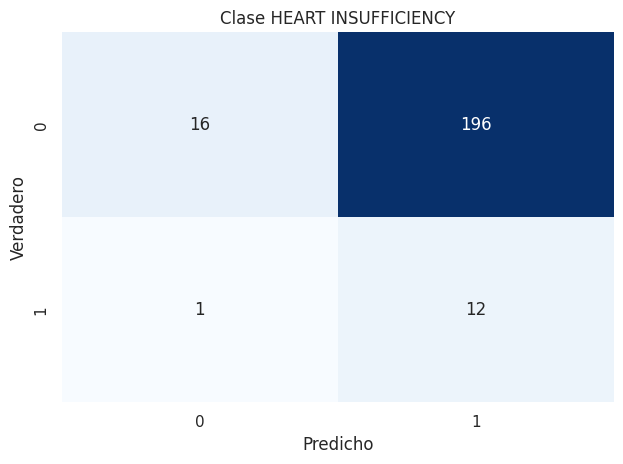

In [97]:
ConfusionMatrix(1, Y_test_INS.reshape(-1,1),
                np.array(predicciones_binarias_resnet_INS).T.reshape(-1,1),
                ["HEART INSUFFICIENCY"],
                "binary"
                )

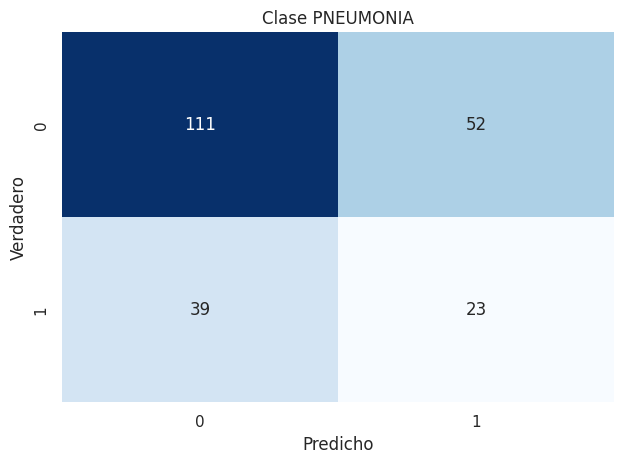

In [98]:
ConfusionMatrix(1, Y_test_PNE.reshape(-1,1),
                np.array(predicciones_binarias_resnet_PNE).T.reshape(-1,1),
                ["PNEUMONIA"],
                "binary")

In [84]:
import numpy as np

# Concatenar las predicciones de los tres modelos en un solo array
probabilities = np.concatenate((predicciones_resnet_COPD, predicciones_resnet_INS, predicciones_resnet_PNE), axis=1)

# Umbral para cada clase
thresholds = [0.013672445, 0.0031571246, 0.29333004]
# Definición de clases
class_copd = 0
class_ins = 1
class_normal = 2
class_pne = 3

# Lista para almacenar las predicciones del ensemble
predicciones_resnet_ensemble = []

# Iterar sobre cada conjunto de probabilidades
for i in range(probabilities.shape[0]):
    votes = [0, 0, 0]  # COPD, INS, PNE

    # Contar votos para cada clase si la probabilidad supera el umbral
    for j in range(3):
        if probabilities[i, j] > thresholds[j]:
            votes[j] += 1

    if max(votes) == 0:
        # Si no hay votos que superen los umbrales, asignar clase normal
        predicciones_resnet_ensemble.append(class_normal)
    else:
        # Elegir la clase con más votos
        max_votes = max(votes)
        candidates = [index for index, value in enumerate(votes) if value == max_votes]
        if len(candidates) > 1:
            # Empate: seleccionar la clase cuya diferencia entre la probabilidad y el umbral sea mayor
            max_diff_index = candidates[np.argmax([probabilities[i, idx] - thresholds[idx] for idx in candidates])]
            predicciones_resnet_ensemble.append([class_copd, class_ins, class_pne][max_diff_index])
        else:
            # Sin empate: asignar la clase directamente
            predicciones_resnet_ensemble.append([class_copd, class_ins, class_pne][candidates[0]])

# Imprimir o retornar las predicciones del ensemble
print(predicciones_resnet_ensemble)
# return predicciones_cxr_ensemble  # Descomentar si se desea retornar en una función


[2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [86]:
test_resnet = np.concatenate((Y_test_COPD.reshape(-1,1),
                       Y_test_INS.reshape(-1,1),
                       Y_test_PNE.reshape(-1,1)), axis = 1)


# Crear una nueva columna para insertar
new_column = np.zeros((test_resnet.shape[0], 1), dtype=int)

# Encontrar filas donde todos los valores son cero
mask = (test_resnet == 0).all(axis=1).reshape(-1,1)

new_column[mask] = 1
new_column.reshape(-1,1)
test_final_resnet = np.insert(test_resnet, 2, new_column.flatten(), axis=1)
test_final_resnet = np.argmax(test_final_resnet, axis = 1)

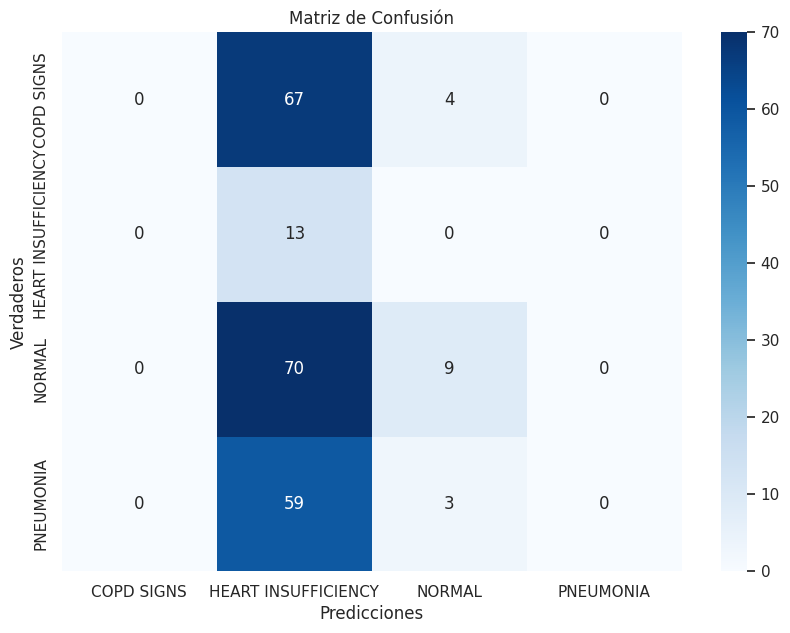

In [87]:
ConfusionMatrixEnsemble(4,
                        test_final_resnet,
                        predicciones_resnet_ensemble,
                         ["COPD SIGNS","HEART INSUFFICIENCY","NORMAL","PNEUMONIA"],
                        "multiclass")